# Setting Up NBA Database

In [ ]:
%load_ext sql

# Create a fresh DB for NBA analytics
!dropdb -U student nba_project --if-exists
!createdb -U student nba_project

# Connect
%sql postgresql://student@/nba_project

Connecting to 'postgresql://student@/nba_project'

# Downloading Kaggle Data Set From Web Link and placeing them in the newly created data folder

In [ ]:
# Install & import KaggleHub
!pip install kagglehub
import kagglehub
import os
import shutil

# Download dataset (version number auto-handled)
path = kagglehub.dataset_download("eoinamoore/historical-nba-data-and-player-box-scores")
print("Dataset downloaded to:", path)

# Create /data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Copy relevant CSVs into working directory: a stable location
files_to_copy = [
    "TeamStatistics.csv",
    "PlayerStatistics.csv",
    "Players.csv"
]

for file in files_to_copy:
    src = os.path.join(path, file)     # dynamically pulls correct path
    dst = os.path.join("data", file)
    shutil.copy(src, dst)

print("Files copied to /data folder successfully!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Dataset downloaded to: /home/ubuntu/.cache/kagglehub/datasets/eoinamoore/historical-nba-data-and-player-box-scores/versions/301
Files copied to /data folder successfully!


In [ ]:
!ls data

PlayerStatistics.csv  Players.csv  TeamStatistics.csv


# Team Statistics

## See CSV TeamStatistic Columns & Seeing How many Records Exist

In [ ]:
!csvcut -n data/TeamStatistics.csv
!wc -l data/TeamStatistics.csv

  1: gameId
  2: gameDateTimeEst
  3: teamCity
  4: teamName
  5: teamId
  6: opponentTeamCity
  7: opponentTeamName
  8: opponentTeamId
  9: home
 10: win
 11: teamScore
 12: opponentScore
 13: assists
 14: blocks
 15: steals
 16: fieldGoalsAttempted
 17: fieldGoalsMade
 18: fieldGoalsPercentage
 19: threePointersAttempted
 20: threePointersMade
 21: threePointersPercentage
 22: freeThrowsAttempted
 23: freeThrowsMade
 24: freeThrowsPercentage
 25: reboundsDefensive
 26: reboundsOffensive
 27: reboundsTotal
 28: foulsPersonal
 29: turnovers
 30: plusMinusPoints
 31: numMinutes
 32: q1Points
 33: q2Points
 34: q3Points
 35: q4Points
 36: benchPoints
 37: biggestLead
 38: biggestScoringRun
 39: leadChanges
 40: pointsFastBreak
 41: pointsFromTurnovers
 42: pointsInThePaint
 43: pointsSecondChance
 44: timesTied
 45: timeoutsRemaining
 46: seasonWins
 47: seasonLosses
 48: coachId
144631 data/TeamStatistics.csv


Inspecting Team Statiscs Data to see what types of values we are dealing with and checking to see if it contains null values.

In [ ]:
!head -n 10000 data/TeamStatistics.csv| csvstat

  1. "gameId"

	Type of data:          Number
	Contains null values:  False
	Non-null values:       9999
	Unique values:         5000
	Smallest value:        12200001
	Largest value:         62400001
	Sum:                   232693430652
	Mean:                  23271670.232
	Median:                22300684
	StDev:                 6013786.012
	Most decimal places:   0
	Most common values:    22501208 (2x)
	                       22501206 (2x)
	                       22501207 (2x)
	                       22501205 (2x)
	                       22501204 (2x)

  2. "gameDateTimeEst"

	Type of data:          Text
	Contains null values:  False
	Non-null values:       9999
	Unique values:         3259
	Longest value:         25 characters
	Most common values:    2025-04-13 15:30:00 (16x)
	                       2024-04-14 15:30:00 (16x)
	                       2023-04-09 13:00:00 (16x)
	                       2022-11-25 20:00:00 (16x)
	                       2025-04-13 13:00:00 (14x)

  3. "team

### Observation on Team Statistics

We see that Team Stats has multiple columns with null values. So, we will have to adjust the data before loading it into a table.

# Creating the Raw Team Statitics Table
Since there we so many Null Values we are cleaning the nulls so they do not cause any error when running the tables

In [ ]:
# Replace quoted empty numeric fields ("") with NULL
!sed -i 's/""/NULL/g' /home/ubuntu/data/TeamStatistics.csv

# Replace , , or ,NULL, edge cases
!sed -i 's/,,/,NULL,/g' /home/ubuntu/data/TeamStatistics.csv

# Fix rows where last column is empty
!sed -i 's/,$/,NULL/' /home/ubuntu/data/TeamStatistics.csv

In [ ]:
%%sql
DROP TABLE IF EXISTS team_stats_raw;

CREATE TABLE team_stats_raw (
    gameId BIGINT,
    gameDateTimeEst TIMESTAMP,
    teamCity VARCHAR(50),
    teamName VARCHAR(50),
    teamId BIGINT,
    opponentTeamCity VARCHAR(50),
    opponentTeamName VARCHAR(50),
    opponentTeamId BIGINT,
    home INT,
    win INT,
    teamScore FLOAT,
    opponentScore FLOAT,
    assists FLOAT,
    blocks FLOAT,
    steals FLOAT,
    fieldGoalsAttempted FLOAT,
    fieldGoalsMade FLOAT,
    fieldGoalsPercentage FLOAT,
    threePointersAttempted FLOAT,
    threePointersMade FLOAT,
    threePointersPercentage FLOAT,
    freeThrowsAttempted FLOAT,
    freeThrowsMade FLOAT,
    freeThrowsPercentage FLOAT,
    reboundsDefensive FLOAT,
    reboundsOffensive FLOAT,
    reboundsTotal FLOAT,
    foulsPersonal FLOAT,
    turnovers FLOAT,
    plusMinusPoints FLOAT,
    numMinutes FLOAT,
    q1Points FLOAT,
    q2Points FLOAT,
    q3Points FLOAT,
    q4Points FLOAT,
    benchPoints FLOAT,
    biggestLead FLOAT,
    biggestScoringRun FLOAT,
    leadChanges FLOAT,
    pointsFastBreak FLOAT,
    pointsFromTurnovers FLOAT,
    pointsInThePaint FLOAT,
    pointsSecondChance FLOAT,
    timesTied FLOAT,
    timeoutsRemaining FLOAT,
    seasonWins FLOAT,
    seasonLosses FLOAT,
    coachId FLOAT
);

Running query in 'postgresql://student@/nba_project'

++
||
++
++

### Copying the team stats from our data into the new table

In [ ]:
%%sql
COPY team_stats_raw
FROM '/home/ubuntu/data/TeamStatistics.csv'
CSV HEADER NULL 'NULL';

Running query in 'postgresql://student@/nba_project'

144630 rows affected.

++
||
++
++

In [ ]:
#I have added this part and comments need DELETING
!wc data/TeamStatistics.csv

  144631   374029 39958885 data/TeamStatistics.csv


In [ ]:
%%sql
SELECT COUNT(*) FROM team_stats_raw;

Running query in 'postgresql://student@/nba_project'

1 rows affected.

count
144630


Row counts on both the raw data and the table create are equal (the one from the table is one less because it doesn't count the header).

Looking at the first 10 rows of our table, combined with the word count shows that our data has been loaded as we wanted.

In [ ]:
%%sql
SELECT * FROM team_stats_raw LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gameid,gamedatetimeest,teamcity,teamname,teamid,opponentteamcity,opponentteamname,opponentteamid,home,win,teamscore,opponentscore,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,numminutes,q1points,q2points,q3points,q4points,benchpoints,biggestlead,biggestscoringrun,leadchanges,pointsfastbreak,pointsfromturnovers,pointsinthepaint,pointssecondchance,timestied,timeoutsremaining,seasonwins,seasonlosses,coachid
22501208,2025-12-11 17:00:00,Denver,Nuggets,1610612743,Sacramento,Kings,1610612758,0,1,136.0,105.0,35.0,0.0,9.0,88.0,52.0,0.591,29.0,12.0,0.414,29.0,20.0,0.69,36.0,10.0,46.0,18.0,12.0,31.0,240.0,41.0,36.0,32.0,27.0,50.0,37.0,13.0,3.0,13.0,15.0,66.0,18.0,5.0,0.0,18.0,6.0,None
22501208,2025-12-11 17:00:00,Sacramento,Kings,1610612758,Denver,Nuggets,1610612743,1,0,105.0,136.0,21.0,4.0,9.0,87.0,39.0,0.448,38.0,11.0,0.289,23.0,16.0,0.696,28.0,10.0,38.0,20.0,16.0,-31.0,240.0,26.0,28.0,27.0,24.0,45.0,2.0,9.0,3.0,12.0,16.0,46.0,12.0,5.0,1.0,6.0,19.0,None
22501206,2025-12-11 15:00:00,Boston,Celtics,1610612738,Milwaukee,Bucks,1610612749,0,0,101.0,116.0,18.0,1.0,7.0,88.0,34.0,0.386,49.0,14.0,0.286,25.0,19.0,0.76,26.0,13.0,39.0,15.0,13.0,-15.0,240.0,35.0,32.0,13.0,21.0,20.0,14.0,13.0,4.0,14.0,16.0,28.0,10.0,5.0,0.0,15.0,10.0,None
22501207,2025-12-11 15:00:00,New Orleans,Pelicans,1610612740,Portland,Trail Blazers,1610612757,1,1,143.0,120.0,36.0,8.0,10.0,112.0,58.0,0.518,32.0,12.0,0.375,17.0,15.0,0.882,38.0,19.0,57.0,16.0,8.0,23.0,240.0,39.0,31.0,35.0,38.0,64.0,25.0,10.0,16.0,17.0,16.0,88.0,24.0,5.0,1.0,4.0,22.0,None
22501205,2025-12-11 15:00:00,Houston,Rockets,1610612745,LA,Clippers,1610612746,1,1,115.0,113.0,26.0,1.0,9.0,93.0,43.0,0.462,34.0,12.0,0.353,21.0,17.0,0.81,29.0,22.0,51.0,22.0,18.0,2.0,240.0,29.0,22.0,29.0,35.0,31.0,9.0,12.0,2.0,24.0,18.0,56.0,23.0,6.0,0.0,16.0,6.0,None
22501205,2025-12-11 15:00:00,LA,Clippers,1610612746,Houston,Rockets,1610612745,0,0,113.0,115.0,25.0,5.0,15.0,78.0,39.0,0.5,38.0,14.0,0.368,26.0,21.0,0.808,20.0,8.0,28.0,20.0,15.0,-2.0,240.0,29.0,25.0,28.0,31.0,16.0,7.0,6.0,2.0,9.0,21.0,46.0,12.0,6.0,0.0,6.0,19.0,None
22501206,2025-12-11 15:00:00,Milwaukee,Bucks,1610612749,Boston,Celtics,1610612738,1,1,116.0,101.0,28.0,5.0,5.0,79.0,46.0,0.582,29.0,13.0,0.448,14.0,11.0,0.786,35.0,5.0,40.0,24.0,15.0,15.0,240.0,29.0,31.0,27.0,29.0,40.0,21.0,11.0,4.0,11.0,23.0,50.0,13.0,5.0,1.0,11.0,15.0,None
22501207,2025-12-11 15:00:00,Portland,Trail Blazers,1610612757,New Orleans,Pelicans,1610612740,0,0,120.0,143.0,27.0,7.0,5.0,102.0,45.0,0.441,48.0,14.0,0.292,22.0,16.0,0.727,28.0,13.0,41.0,19.0,15.0,-23.0,240.0,30.0,38.0,29.0,23.0,45.0,2.0,6.0,16.0,25.0,14.0,62.0,21.0,5.0,1.0,9.0,16.0,None
22501204,2025-12-10 17:00:00,Los Angeles,Lakers,1610612747,San Antonio,Spurs,1610612759,1,0,119.0,132.0,27.0,7.0,4.0,87.0,43.0,0.494,37.0,16.0,0.432,23.0,17.0,0.739,37.0,6.0,43.0,23.0,11.0,-13.0,240.0,30.0,28.0,29.0,32.0,31.0,6.0,11.0,5.0,21.0,11.0,52.0,2.0,2.0,1.0,17.0,7.0,None
22501204,2025-12-10 17:00:00,San Antonio,Spurs,1610612759,Los Angeles,Lakers,1610612747,0,1,132.0,119.0,25.0,3.0,9.0,86.0,43.0,0.5,38.0,17.0,0.447,36.0,29.0,0.806,41.0,9.0,50.0,19.0,10.0,13.0,240.0,39.0,31.0,34.0,28.0,48.0,24.0,11.0,5.0,27.0,16.0,46.0,11.0,2.0,1.0,17.0,7.0,None


# Player Statistics

## See CSV Player Statistic Columns & Seeing How many Records Exist

In [ ]:
!csvcut -n data/PlayerStatistics.csv
!wc -l data/PlayerStatistics.csv

  1: firstName
  2: lastName
  3: personId
  4: gameId
  5: gameDateTimeEst
  6: playerteamCity
  7: playerteamName
  8: opponentteamCity
  9: opponentteamName
 10: gameType
 11: gameLabel
 12: gameSubLabel
 13: seriesGameNumber
 14: win
 15: home
 16: numMinutes
 17: points
 18: assists
 19: blocks
 20: steals
 21: fieldGoalsAttempted
 22: fieldGoalsMade
 23: fieldGoalsPercentage
 24: threePointersAttempted
 25: threePointersMade
 26: threePointersPercentage
 27: freeThrowsAttempted
 28: freeThrowsMade
 29: freeThrowsPercentage
 30: reboundsDefensive
 31: reboundsOffensive
 32: reboundsTotal
 33: foulsPersonal
 34: turnovers
 35: plusMinusPoints
1639528 data/PlayerStatistics.csv


Inspecting Player Statistics Data to see what types of values we are dealing with and checking to see if it contains null values.

In [ ]:
!head -n 10000 data/PlayerStatistics.csv| csvstat

  1. "firstName"

	Type of data:          Text
	Contains null values:  False
	Non-null values:       9999
	Unique values:         434
	Longest value:         15 characters
	Most common values:    Jalen (169x)
	                       Jordan (133x)
	                       Isaiah (125x)
	                       Josh (97x)
	                       Kyle (91x)

  2. "lastName"

	Type of data:          Text
	Contains null values:  False
	Non-null values:       9999
	Unique values:         478
	Longest value:         18 characters
	Most common values:    Williams (169x)
	                       Johnson (138x)
	                       Jones (119x)
	                       Green (97x)
	                       Brown (76x)

  3. "personId"

	Type of data:          Number
	Contains null values:  False
	Non-null values:       9999
	Unique values:         579
	Smallest value:        2544
	Largest value:         1643148
	Sum:                   14416172719
	Mean:                  1441761.448
	Median:        

#### Observation on Player statistics

 We see that Player Stats has multiple columns have null Values so we will have to adjust the data before loading it into a table.

# Cleaning the Raw Player Stats Table
since there we so many Null Values we are cleaning the nulls so they do not cause any error when running the tables

In [ ]:
# Replace empty quoted values "" with NULL
!sed -i 's/""/NULL/g' /home/ubuntu/data/PlayerStatistics.csv

# Convert blank fields to NULL
!sed -i 's/,,/,NULL,/g' /home/ubuntu/data/PlayerStatistics.csv

# Fix missing last values
!sed -i 's/,$/,NULL/' /home/ubuntu/data/PlayerStatistics.csv


In [ ]:
%%sql
DROP TABLE IF EXISTS player_stats_raw;

CREATE TABLE player_stats_raw (
    firstName VARCHAR(50),
    lastName VARCHAR(50),
    personId BIGINT,
    gameId BIGINT,
    gameDateTimeEst TIMESTAMP,
    playerteamCity VARCHAR(50),
    playerteamName VARCHAR(50),
    opponentteamCity VARCHAR(50),
    opponentteamName VARCHAR(50),
    gameType VARCHAR(50),
    gameLabel VARCHAR(50),
    gameSubLabel VARCHAR(50),
    seriesGameNumber VARCHAR(50),
    win INT,
    home INT,
    numMinutes FLOAT,
    points FLOAT,
    assists FLOAT,
    blocks FLOAT,
    steals FLOAT,
    fieldGoalsAttempted FLOAT,
    fieldGoalsMade FLOAT,
    fieldGoalsPercentage FLOAT,
    threePointersAttempted FLOAT,
    threePointersMade FLOAT,
    threePointersPercentage FLOAT,
    freeThrowsAttempted FLOAT,
    freeThrowsMade FLOAT,
    freeThrowsPercentage FLOAT,
    reboundsDefensive FLOAT,
    reboundsOffensive FLOAT,
    reboundsTotal FLOAT,
    foulsPersonal FLOAT,
    turnovers FLOAT,
    plusMinusPoints FLOAT
);


Running query in 'postgresql://student@/nba_project'

++
||
++
++

In [ ]:
%%sql
COPY player_stats_raw
FROM '/home/ubuntu/data/PlayerStatistics.csv'
CSV HEADER NULL 'NULL';

Running query in 'postgresql://student@/nba_project'

1639527 rows affected.

++
||
++
++

Validating it was loaded Correctly

In [ ]:
!wc data/PlayerStatistics.csv

  1639528   5984206 328354553 data/PlayerStatistics.csv


In [ ]:
%%sql
SELECT COUNT(*) FROM player_stats_raw;

Running query in 'postgresql://student@/nba_project'

1 rows affected.

count
1639527


In [ ]:
%%sql
SELECT * FROM player_stats_raw LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

firstname,lastname,personid,gameid,gamedatetimeest,playerteamcity,playerteamname,opponentteamcity,opponentteamname,gametype,gamelabel,gamesublabel,seriesgamenumber,win,home,numminutes,points,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints
Jamal,Murray,1627750,22501208,2025-12-11 17:00:00,Denver,Nuggets,Sacramento,Kings,None,None,None,None,1,0,25.42,11.0,9.0,0.0,2.0,13.0,4.0,0.308,4.0,1.0,0.25,3.0,2.0,0.667,3.0,0.0,3.0,1.0,1.0,24.0
Malik,Monk,1628370,22501208,2025-12-11 17:00:00,Sacramento,Kings,Denver,Nuggets,None,None,None,None,0,1,30.07,18.0,5.0,0.0,1.0,11.0,5.0,0.455,6.0,3.0,0.5,6.0,5.0,0.833,3.0,1.0,4.0,0.0,5.0,-19.0
Bruce,Brown,1628971,22501208,2025-12-11 17:00:00,Denver,Nuggets,Sacramento,Kings,None,None,None,None,1,0,26.14,8.0,7.0,0.0,1.0,5.0,2.0,0.4,1.0,0.0,0.0,4.0,4.0,1.0,3.0,2.0,5.0,2.0,3.0,6.0
Drew,Eubanks,1629234,22501208,2025-12-11 17:00:00,Sacramento,Kings,Denver,Nuggets,None,None,None,None,0,1,3.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-12.0
Jalen,Pickett,1629618,22501208,2025-12-11 17:00:00,Denver,Nuggets,Sacramento,Kings,None,None,None,None,1,0,24.58,6.0,4.0,0.0,2.0,6.0,2.0,0.333,5.0,2.0,0.4,0.0,0.0,0.0,5.0,0.0,5.0,0.0,2.0,11.0
Cameron,Johnson,1629661,22501208,2025-12-11 17:00:00,Denver,Nuggets,Sacramento,Kings,None,None,None,None,1,0,32.34,16.0,1.0,0.0,1.0,13.0,6.0,0.462,5.0,1.0,0.2,4.0,3.0,0.75,2.0,1.0,3.0,1.0,1.0,17.0
Precious,Achiuwa,1630173,22501208,2025-12-11 17:00:00,Sacramento,Kings,Denver,Nuggets,None,None,None,None,0,1,9.55,4.0,0.0,0.0,0.0,4.0,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,6.0,4.0,0.0,2.0
Zeke,Nnaji,1630192,22501208,2025-12-11 17:00:00,Denver,Nuggets,Sacramento,Kings,None,None,None,None,1,0,6.11,2.0,0.0,0.0,1.0,2.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,-3.0
Keegan,Murray,1631099,22501208,2025-12-11 17:00:00,Sacramento,Kings,Denver,Nuggets,None,None,None,None,0,1,27.31,15.0,1.0,2.0,2.0,13.0,7.0,0.538,5.0,1.0,0.2,2.0,0.0,0.0,4.0,2.0,6.0,3.0,1.0,-12.0
Keon,Ellis,1631165,22501208,2025-12-11 17:00:00,Sacramento,Kings,Denver,Nuggets,None,None,None,None,0,1,31.22,8.0,4.0,1.0,4.0,9.0,3.0,0.333,7.0,1.0,0.143,3.0,1.0,0.333,1.0,1.0,2.0,2.0,1.0,-14.0


Row counts matching, and data correctly loaded into the table `player_stats_raw` as we expected.

# Players

## See CSV Players Columns & Seeing How many Records Exist

In [ ]:
!csvcut -n data/Players.csv
!wc -l data/Players.csv

  1: personId
  2: firstName
  3: lastName
  4: birthdate
  5: lastAttended
  6: country
  7: height
  8: bodyWeight
  9: guard
 10: forward
 11: center
 12: draftYear
 13: draftRound
 14: draftNumber
6680 data/Players.csv


Inspecting Player Statistics Data to see what types of values we are dealing with and checking to see if it contains null values.

In [ ]:
!head -n 5000 data/Players.csv| csvstat

  1. "personId"

	Type of data:          Number
	Contains null values:  False
	Non-null values:       4999
	Unique values:         4999
	Smallest value:        3
	Largest value:         1966938209
	Sum:                   207234218707
	Mean:                  41455134.768
	Median:                77469
	StDev:                 263809372.603
	Most decimal places:   0
	Most common values:    196294611 (1x)
	                       43217 (1x)
	                       196294534 (1x)
	                       76001 (1x)
	                       76002 (1x)

  2. "firstName"

	Type of data:          Text
	Contains null values:  True (excluded from calculations)
	Non-null values:       4998
	Unique values:         1791
	Longest value:         15 characters
	Most common values:    John (68x)
	                       Bob (62x)
	                       Chris (54x)
	                       Mike (50x)
	                       Jim (49x)

  3. "lastName"

	Type of data:          Text
	Contains null values:  True 

#### Observation on Players
 We see that Player Stats has multiple columns with null Values. So we will have to adjust the data before loading it into a table.

# Cleaning the Raw Player Table
Since there we so many Null Values we are cleaning the nulls so they do not cause any error when running the tables

In [ ]:
# 1) Replace "", None, blank fields → NULL
!sed -i 's/""/NULL/g' /home/ubuntu/data/Players.csv
!sed -i 's/,[[:space:]]*,/,NULL,/g' /home/ubuntu/data/Players.csv   # ", ,"
!sed -i 's/,,/,NULL,/g' /home/ubuntu/data/Players.csv               # ",,"
!sed -i 's/None/NULL/g' /home/ubuntu/data/Players.csv

# 2) Fix draft anomalies (-1 and -22 → NULL)
!sed -i 's/,-1,/,NULL,/g'  /home/ubuntu/data/Players.csv
!sed -i 's/,-22,/,NULL,/g' /home/ubuntu/data/Players.csv

# 3) Convert True/False → 1/0 (guard, forward, center flags)
#    (these values only appear in those flag columns)
!sed -i 's/,True,/,1,/g'  /home/ubuntu/data/Players.csv
!sed -i 's/,False,/,0,/g' /home/ubuntu/data/Players.csv

# 4) Remove height outliers (<65 or >90 inches) → NULL
#    height is column 7
!awk -F',' 'BEGIN{OFS=","} NR>1 { if ($7 < 65 || $7 > 90) $7="NULL"}1' \
  /home/ubuntu/data/Players.csv > /home/ubuntu/data/tmp1.csv \
  && mv /home/ubuntu/data/tmp1.csv /home/ubuntu/data/Players.csv

# 5) Remove weight outliers (<120 or >400 lbs) → NULL
#    bodyWeight is column 8
!awk -F',' 'BEGIN{OFS=","} NR>1 { if ($8 < 120 || $8 > 400) $8="NULL"}1' \
  /home/ubuntu/data/Players.csv > /home/ubuntu/data/tmp2.csv \
  && mv /home/ubuntu/data/tmp2.csv /home/ubuntu/data/Players.csv

In [ ]:
%%sql
DROP TABLE IF EXISTS players_raw;

CREATE TABLE players_raw (
    personId BIGINT,
    firstName VARCHAR(50),
    lastName VARCHAR(50),
    birthdate DATE,
    lastAttended VARCHAR(100),
    country VARCHAR(50),
    height FLOAT,
    bodyWeight FLOAT,
    guard VARCHAR(10),
    forward VARCHAR(10),
    center VARCHAR(10),
    draftYear FLOAT,
    draftRound FLOAT,
    draftNumber FLOAT
);

Running query in 'postgresql://student@/nba_project'

++
||
++
++

In [ ]:
%%sql
COPY players_raw
FROM '/home/ubuntu/data/Players.csv'
CSV HEADER NULL 'NULL';

Running query in 'postgresql://student@/nba_project'

6679 rows affected.

++
||
++
++

Validating it was loaded Correctly

In [ ]:
!wc -l /home/ubuntu/data/Players.csv

6680 /home/ubuntu/data/Players.csv


In [ ]:
%%sql
SELECT COUNT(*) FROM players_raw;

Running query in 'postgresql://student@/nba_project'

1 rows affected.

count
6679


Once again, the rows counts match, with the header not counted on the table.

Preveiwing the First couple of rows of the players raw table

In [ ]:
%%sql
SELECT * FROM players_raw LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

personid,firstname,lastname,birthdate,lastattended,country,height,bodyweight,guard,forward,center,draftyear,draftround,draftnumber
196294611,Olivinha,None,None,None,None,None,None,None,None,None,None,None,None
43217,Olivinha,None,None,None,None,None,None,None,None,None,None,None,None
196294534,Alberto,Abalde,None,None,None,None,None,None,None,None,None,None,None
76001,Alaa,Abdelnaby,1968-06-24,Duke,USA,82.0,240.0,0,1,0,1990.0,1.0,25.0
76002,Zaid,Abdul-Aziz,1946-04-07,Iowa State,USA,81.0,None,0,False,1,1968.0,1.0,5.0
76003,Kareem,Abdul-Jabbar,1947-04-16,UCLA,USA,86.0,225.0,0,False,1,1969.0,1.0,1.0
51,Mahmoud,Abdul-Rauf,1969-03-09,Louisiana State,USA,73.0,None,1,0,False,1990.0,1.0,3.0
1505,Tariq,Abdul-Wahad,1974-11-03,San Jose State,France,78.0,235.0,1,True,0,1997.0,1.0,11.0
949,Shareef,Abdur-Rahim,1976-12-11,California,USA,81.0,245.0,0,1,0,1996.0,1.0,3.0
1627114,Tom,Abercrombie,None,None,None,None,None,None,None,None,None,None,None


We see we are getting mixed results in the Gaurd, Foward, Center Column so we have to clean and adjust that from true/false to 1/0

In [ ]:
%%sql
UPDATE players_raw
SET
    guard = CASE
                WHEN guard IN ('True', 'true', '1') THEN 1
                WHEN guard IN ('False', 'false', '0') THEN 0
                ELSE NULL
            END,
    forward = CASE
                WHEN forward IN ('True', 'true', '1') THEN 1
                WHEN forward IN ('False', 'false', '0') THEN 0
                ELSE NULL
            END,
    center = CASE
                WHEN center IN ('True', 'true', '1') THEN 1
                WHEN center IN ('False', 'false', '0') THEN 0
                ELSE NULL
            END;


Running query in 'postgresql://student@/nba_project'

6679 rows affected.

++
||
++
++

Now we will convert them into numeric/ integer fields

In [ ]:
%%sql
ALTER TABLE players_raw
ALTER COLUMN guard TYPE INT USING guard::INT,
ALTER COLUMN forward TYPE INT USING forward::INT,
ALTER COLUMN center TYPE INT USING center::INT;

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Checking the table for correctness again

In [ ]:
%%sql
SELECT personId, firstName, lastName, guard, forward, center
FROM players_raw
WHERE guard IS NOT NULL OR forward IS NOT NULL OR center IS NOT NULL
LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

personid,firstname,lastname,guard,forward,center
1627759,Jaylen,Brown,0,0,0
202692,Alec,Burks,1,0,0
196294585,Bruno,Caboclo,0,0,1
196295502,Owen,Foxwell,0,0,0
1629060,Rui,Hachimura,0,0,0
1630174,Aaron,Nesmith,0,1,0
690,Don,Reid,0,1,0
1641715,Cam,Whitmore,0,1,0
1629627,Zion,Williamson,0,0,0
1962937553,Willy,Workman,0,0,0


Checking the full Table

In [ ]:
%%sql
SELECT * FROM players_raw LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

personid,firstname,lastname,birthdate,lastattended,country,height,bodyweight,guard,forward,center,draftyear,draftround,draftnumber
1628965,Jaylen,Barford,None,None,None,None,None,None,None,None,None,None,None
500,Barrett,Barrett,None,None,None,None,None,None,None,None,None,None,None
1627759,Jaylen,Brown,None,None,None,None,None,0,0,0,None,None,None
202692,Alec,Burks,None,None,None,None,None,1,0,0,None,None,None
196294585,Bruno,Caboclo,None,None,None,None,None,0,0,1,None,None,None
1969,Peter,Cornell,None,None,None,None,None,None,None,None,None,None,None
1962937441,Luka,Doncic,None,None,None,None,None,None,None,None,None,None,None
56033,Antonios,Fotsis,None,None,None,None,None,None,None,None,None,None,None
196295504,Austin,Foxwell,None,None,None,None,None,None,None,None,None,None,None
196295502,Owen,Foxwell,None,None,None,None,None,0,0,0,None,None,None


We are seeing negtive numbers in the Draft year, when we further inspect the CSV we see the common -1.0 and -22. We will clean the table for those numbers as well

In [ ]:
%%sql
UPDATE players_raw
SET
    draftYear = CASE WHEN draftYear IN (-1, -22) THEN NULL ELSE draftYear END,
    draftRound = CASE WHEN draftRound IN (-1, -22) THEN NULL ELSE draftRound END,
    draftNumber = CASE WHEN draftNumber IN (-1, -22) THEN NULL ELSE draftNumber END;

Running query in 'postgresql://student@/nba_project'

6679 rows affected.

++
||
++
++

Checking the table one more time

In [ ]:
%%sql
SELECT * FROM players_raw LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

personid,firstname,lastname,birthdate,lastattended,country,height,bodyweight,guard,forward,center,draftyear,draftround,draftnumber
1628965,Jaylen,Barford,None,None,None,None,None,None,None,None,None,None,None
1629190,C.J.,Anderson,None,None,None,None,None,None,None,None,None,None,None
196295055,Sean,Bairstow,None,None,None,None,None,None,None,None,None,None,None
44051,Lubos,Barton,None,None,None,None,None,None,None,None,None,None,None
27032,Gal,Baruch,None,None,None,None,None,None,None,None,None,None,None
203155,Oscar,Bellfield,None,None,None,None,None,None,None,None,None,None,None
41004,Milko,Bjelica,None,None,None,None,None,None,None,None,None,None,None
560,de la Fuente,de la Fuente,None,None,None,None,None,None,None,None,None,None,None
1642365,Nikola,Đurisic,None,None,None,None,None,None,None,None,None,None,None
1630817,Pedro,Bradshaw,None,None,None,None,None,None,None,None,None,None,None


Viewing how many rows have full values we will do quick check for each column how many null values we will have  before we start

In [ ]:
%%sql
SELECT
    SUM(CASE WHEN personId IS NULL THEN 1 ELSE 0 END) AS personId_nulls,
    SUM(CASE WHEN firstName IS NULL THEN 1 ELSE 0 END) AS firstName_nulls,
    SUM(CASE WHEN lastName IS NULL THEN 1 ELSE 0 END) AS lastName_nulls,
    SUM(CASE WHEN birthdate IS NULL THEN 1 ELSE 0 END) AS birthdate_nulls,
    SUM(CASE WHEN lastAttended IS NULL THEN 1 ELSE 0 END) AS lastAttended_nulls,
    SUM(CASE WHEN country IS NULL THEN 1 ELSE 0 END) AS country_nulls,
    SUM(CASE WHEN height IS NULL THEN 1 ELSE 0 END) AS height_nulls,
    SUM(CASE WHEN bodyWeight IS NULL THEN 1 ELSE 0 END) AS bodyWeight_nulls,
    SUM(CASE WHEN guard IS NULL THEN 1 ELSE 0 END) AS guard_nulls,
    SUM(CASE WHEN forward IS NULL THEN 1 ELSE 0 END) AS forward_nulls,
    SUM(CASE WHEN center IS NULL THEN 1 ELSE 0 END) AS center_nulls,
    SUM(CASE WHEN draftYear IS NULL THEN 1 ELSE 0 END) AS draftYear_nulls,
    SUM(CASE WHEN draftRound IS NULL THEN 1 ELSE 0 END) AS draftRound_nulls,
    SUM(CASE WHEN draftNumber IS NULL THEN 1 ELSE 0 END) AS draftNumber_nulls
FROM players_raw;


Running query in 'postgresql://student@/nba_project'

1 rows affected.

personid_nulls,firstname_nulls,lastname_nulls,birthdate_nulls,lastattended_nulls,country_nulls,height_nulls,bodyweight_nulls,guard_nulls,forward_nulls,center_nulls,draftyear_nulls,draftround_nulls,draftnumber_nulls
0,1,2,2003,2026,2006,2230,2938,1559,1559,1559,3386,3548,3606


This gives us an idea of what values will be best for analysis later

In [ ]:
from IPython.display import Image
Image(url="https://raw.githubusercontent.com/kjcline-spec/NBA-Analytics-Final-Project/main/images/NBA%20Base%20Schema_v3.png")

# Showing the base schema of the two base databases that we are using to make our star schema from

# Now from our Baseline Schema we built our star schema to focous on player performance as our main fact table

In [ ]:
from IPython.display import Image
Image(url="https://raw.githubusercontent.com/kjcline-spec/NBA-Analytics-Final-Project/main/images/NBA%20Star%20Schema_v4.png")

# Creating dimension and fact tables

## Working with **PLAYERS** dimension

Let's begin with creating the dimension table **PLAYERS**.

In [ ]:
%%sql
DROP TABLE IF EXISTS players;

CREATE TABLE players(
    playerKey SERIAL PRIMARY KEY,
    personId BIGINT,
    firstName VARCHAR(50),
    lastName VARCHAR(50),
    birthdate DATE,
    lastAttended VARCHAR(100),
    country VARCHAR(50),
    height FLOAT,
    bodyWeight FLOAT,
    guard VARCHAR(10),
    forward VARCHAR(10),
    center VARCHAR(10),
    draftYear FLOAT,
    draftRound FLOAT,
    draftNumber FLOAT
)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

We will now move data from the raw dataset to the players dimension table.

In [ ]:
%%sql
INSERT INTO players (
    personId,
    firstName,
    lastName,
    birthdate,
    lastAttended,
    country,
    height,
    bodyWeight,
    guard,
    forward,
    center,
    draftYear,
    draftRound,
    draftNumber)
SELECT * FROM players_raw

Running query in 'postgresql://student@/nba_project'

6679 rows affected.

++
||
++
++

Checking that it has been loaded properly.

In [ ]:
%%sql
SELECT * FROM players LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

playerkey,personid,firstname,lastname,birthdate,lastattended,country,height,bodyweight,guard,forward,center,draftyear,draftround,draftnumber
1,1628965,Jaylen,Barford,None,None,None,None,None,None,None,None,None,None,None
2,1629190,C.J.,Anderson,None,None,None,None,None,None,None,None,None,None,None
3,196295055,Sean,Bairstow,None,None,None,None,None,None,None,None,None,None,None
4,44051,Lubos,Barton,None,None,None,None,None,None,None,None,None,None,None
5,27032,Gal,Baruch,None,None,None,None,None,None,None,None,None,None,None
6,203155,Oscar,Bellfield,None,None,None,None,None,None,None,None,None,None,None
7,41004,Milko,Bjelica,None,None,None,None,None,None,None,None,None,None,None
8,560,de la Fuente,de la Fuente,None,None,None,None,None,None,None,None,None,None,None
9,1642365,Nikola,Đurisic,None,None,None,None,None,None,None,None,None,None,None
10,1630817,Pedro,Bradshaw,None,None,None,None,None,None,None,None,None,None,None


We're now ready to begin adding connection starting from creating the foreign key.

In [ ]:
%%sql
ALTER TABLE player_stats_raw
ADD COLUMN playerKey INTEGER,
ADD CONSTRAINT fk_player
FOREIGN KEY (playerKey)
REFERENCES players(playerKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Let's now connect this foreign key to the players dimension table.

In [ ]:
%%sql
UPDATE player_stats_raw
SET playerKey = players.playerKey
FROM players
WHERE player_stats_raw.personId = players.personId

Running query in 'postgresql://student@/nba_project'

1639527 rows affected.

++
||
++
++

Checking our player performance fact table

In [ ]:
%%sql
SELECT * FROM player_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

firstname,lastname,personid,gameid,gamedatetimeest,playerteamcity,playerteamname,opponentteamcity,opponentteamname,gametype,gamelabel,gamesublabel,seriesgamenumber,win,home,numminutes,points,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,playerkey
Asa,Newell,1642854,22500340,2025-12-05 14:30:00,Atlanta,Hawks,Denver,Nuggets,None,None,None,None,0,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4384
Oso,Ighodaro,1642345,22500088,2025-10-22 22:00:00,Phoenix,Suns,Sacramento,Kings,None,None,None,None,1,1,19.23,7.0,1.0,0.0,0.0,5.0,3.0,0.6,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,4.0,3.0,1.0,-2.0,2852
Bol,Bol,1629626,22300690,2024-02-02 19:30:00,Phoenix,Suns,Atlanta,Hawks,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697
Bol,Bol,1629626,22300347,2023-12-17 20:00:00,Phoenix,Suns,Washington,Wizards,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697
Bol,Bol,1629626,22300247,2023-11-26 18:00:00,Phoenix,Suns,New York,Knicks,Regular Season,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697
Tony,Bradley,1628396,22200462,2022-12-20 19:30:00,Chicago,Bulls,Miami,Heat,Regular Season,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,785
Udonis,Haslem,2617,22100851,2022-02-12 20:00:00,Miami,Heat,Brooklyn,Nets,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2537
Jared,Butler,1630215,22100141,2021-11-07 18:00:00,Utah,Jazz,Orlando,Magic,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,982
E'Twaun,Moore,202734,22000827,2021-04-13 22:00:00,Phoenix,Suns,Miami,Heat,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4193
Bol,Bol,1629626,22000321,2021-04-06 21:00:00,Denver,Nuggets,Detroit,Pistons,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697


With link connection done, we can remove safely the columns **firstName**, **lastName**, and **personId** from the fact table

In [ ]:
%%sql
ALTER TABLE player_stats_raw
DROP COLUMN firstName,
DROP COLUMN lastName,
DROP COLUMN personId

Running query in 'postgresql://student@/nba_project'

++
||
++
++

In [ ]:
%%sql
SELECT * FROM player_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gameid,gamedatetimeest,playerteamcity,playerteamname,opponentteamcity,opponentteamname,gametype,gamelabel,gamesublabel,seriesgamenumber,win,home,numminutes,points,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,playerkey
22000321,2021-04-06 21:00:00,Denver,Nuggets,Detroit,Pistons,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697
22000352,2021-02-06 17:00:00,Denver,Nuggets,Sacramento,Kings,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697
22000248,2021-01-23 21:00:00,Denver,Nuggets,Phoenix,Suns,Regular Season,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697
21900919,2020-03-04 19:30:00,Miami,Heat,Orlando,Magic,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2683
21900889,2020-02-29 19:30:00,Miami,Heat,Brooklyn,Nets,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2683
21900568,2020-01-10 19:30:00,Miami,Heat,Brooklyn,Nets,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5443
11800007,2018-09-30 17:00:00,Miami,Heat,San Antonio,Spurs,Preseason,None,None,None,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2537
11800042,2018-10-06 22:00:00,Los Angeles,Clippers,Los Angeles,Lakers,Preseason,None,None,None,1,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5123
11800035,2018-10-05 20:30:00,Detroit,Pistons,San Antonio,Spurs,Preseason,None,None,None,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,949
11800028,2018-10-05 07:30:00,Dallas,Mavericks,Philadelphia,76ers,Preseason,None,None,None,0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,456


## Working with **TEAM** dimension

In creating the team dimension, let's begin with the creation of the **teams** table.

In [ ]:
%%sql
DROP TABLE IF EXISTS teams;

CREATE TABLE teams(
    teamKey SERIAL PRIMARY KEY,
    teamName VARCHAR(50),
    teamCity VARCHAR(50),
    coachid FLOAT
)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Now that it's created, let's populate it with the team's **name**, **city**, and **coach**

In [ ]:
%%sql
INSERT INTO teams (teamName, teamCity,coachId)
SELECT DISTINCT teamName, teamCity, coachId
FROM team_stats_raw

Running query in 'postgresql://student@/nba_project'

63 rows affected.

++
||
++
++

Let's take a look at our new table

In [ ]:
%%sql
SELECT * FROM teams

Running query in 'postgresql://student@/nba_project'

63 rows affected.

teamkey,teamname,teamcity,coachid
1,Kings,Kansas City-Omaha,None
2,Wizards,Washington,None
3,76ers,Philadelphia,None
4,Phoenix,South East Melbourne,None
5,Timberwolves,Minnesota,None
6,Royals,Cincinnati,None
7,Nets,Brooklyn,None
8,Nationals,Syracuse,None
9,Jazz,New Orleans,None
10,Grizzlies,Memphis,None


We will now connect the **team**'s table with the player fact table.

First, let's create the column for the foreign key teamKey.

In [ ]:
%%sql
ALTER TABLE team_stats_raw
ADD COLUMN teamKey INTEGER,
ADD CONSTRAINT fk_team
FOREIGN KEY (teamKey)
REFERENCES teams(teamKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Now, we create the connection between the dimension and the fact table.

In [ ]:
%%sql
UPDATE team_stats_raw
SET teamKey = teams.teamKey
FROM teams
WHERE team_stats_raw.teamName = teams.teamName

Running query in 'postgresql://student@/nba_project'

144630 rows affected.

++
||
++
++

We will also do the same with the opponent team field in the team fact table.

In [ ]:
%%sql
ALTER TABLE team_stats_raw
ADD COLUMN opponentTeamKey INTEGER,
ADD CONSTRAINT fk_team_opponent
FOREIGN KEY (opponentTeamKey)
REFERENCES teams(teamKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

With the new foreign key field created, we will now connect it to the teams dimension.

In [ ]:
%%sql
UPDATE team_stats_raw
SET opponentTeamKey = teams.teamKey
FROM teams
WHERE team_stats_raw.opponentTeamName = teams.teamName

Running query in 'postgresql://student@/nba_project'

144630 rows affected.

++
||
++
++

Checking the fact table

In [ ]:
%%sql
SELECT * FROM team_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gameid,gamedatetimeest,teamcity,teamname,teamid,opponentteamcity,opponentteamname,opponentteamid,home,win,teamscore,opponentscore,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,numminutes,q1points,q2points,q3points,q4points,benchpoints,biggestlead,biggestscoringrun,leadchanges,pointsfastbreak,pointsfromturnovers,pointsinthepaint,pointssecondchance,timestied,timeoutsremaining,seasonwins,seasonlosses,coachid,teamkey,opponentteamkey
27900048,1979-10-20 20:00:00,Atlanta,Hawks,1610612737,Houston,Rockets,1610612745,0,0,102.0,107.0,None,None,None,None,44.0,None,None,0.0,None,20.0,14.0,0.7,None,None,None,None,None,-5.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,62
27700331,1977-12-23 20:00:00,Milwaukee,Bucks,1610612749,Atlanta,Hawks,1610612737,1,0,93.0,109.0,None,None,None,None,40.0,None,None,None,None,20.0,13.0,0.65,None,None,None,23.0,None,-16.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,15,55
27300230,1973-12-07 20:00:00,Capital,Bullets,1610612764,Phoenix,Suns,1610612756,0,0,92.0,114.0,None,None,None,None,35.0,None,None,None,None,26.0,22.0,0.846,None,None,None,28.0,None,None,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,38,60
26500228,1966-01-28 19:00:00,Detroit,Pistons,1610612765,Boston,Celtics,1610612738,0,1,108.0,105.0,None,None,None,None,39.0,None,None,None,None,36.0,30.0,0.833,None,None,None,None,None,3.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,58,42
26300358,1964-03-18 19:00:00,St. Louis,Hawks,1610612737,Detroit,Pistons,1610612765,0,0,96.0,106.0,None,None,None,None,33.0,None,None,None,None,41.0,30.0,0.732,None,None,None,None,None,-10.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,58
26100353,1962-03-12 19:00:00,Detroit,Pistons,1610612765,Chicago,Packers,1610612764,1,1,121.0,116.0,None,None,None,None,46.0,None,None,None,None,37.0,29.0,0.784,None,None,None,None,None,5.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,58,14
26100307,1962-02-22 19:00:00,Los Angeles,Lakers,1610612747,New York,Knicks,1610612752,1,1,118.0,116.0,None,None,None,None,45.0,None,None,None,None,None,28.0,None,None,None,None,24.0,None,2.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,28,48
26100082,1961-11-26 19:00:00,Boston,Celtics,1610612738,Detroit,Pistons,1610612765,0,1,107.0,101.0,None,None,None,None,43.0,None,None,None,None,None,21.0,None,None,None,None,None,None,6.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,42,58
26000296,1961-03-04 19:00:00,St. Louis,Hawks,1610612737,Detroit,Pistons,1610612765,1,1,104.0,102.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,58
26000205,1961-01-27 19:00:00,Boston,Celtics,1610612738,Detroit,Pistons,1610612765,1,1,140.0,111.0,None,None,None,None,62.0,None,None,None,None,None,16.0,None,None,None,None,23.0,None,29.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,42,58


It's successfully linked. We can now remove the columns **teamName**, **teamCity**, **coachId**, **opponentTeamName**, and **opponentTeamCity** from the fact table.

In [ ]:
%%sql
ALTER TABLE team_stats_raw
DROP COLUMN teamName,
DROP COLUMN teamCity,
DROP COLUMN coachId,
DROP COLUMN opponentTeamName,
DROP COLUMN opponentTeamCity

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Here is our team fact table now with teamKey and opponentTeamKey inserted.

In [ ]:
%%sql
SELECT * from team_stats_raw
LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gameid,gamedatetimeest,teamid,opponentteamid,home,win,teamscore,opponentscore,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,numminutes,q1points,q2points,q3points,q4points,benchpoints,biggestlead,biggestscoringrun,leadchanges,pointsfastbreak,pointsfromturnovers,pointsinthepaint,pointssecondchance,timestied,timeoutsremaining,seasonwins,seasonlosses,teamkey,opponentteamkey
26100082,1961-11-26 19:00:00,1610612738,1610612765,0,1,107.0,101.0,None,None,None,None,43.0,None,None,None,None,None,21.0,None,None,None,None,None,None,6.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,42,58
26000296,1961-03-04 19:00:00,1610612737,1610612765,1,1,104.0,102.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,58
26000205,1961-01-27 19:00:00,1610612738,1610612765,1,1,140.0,111.0,None,None,None,None,62.0,None,None,None,None,None,16.0,None,None,None,None,23.0,None,29.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,42,58
26000008,1960-10-24 19:00:00,1610612747,1610612752,1,0,101.0,111.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-10.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,28,48
25800279,1959-03-07 19:00:00,1610612737,1610612765,1,1,137.0,128.0,None,None,None,None,44.0,None,None,None,None,None,49.0,None,None,None,None,30.0,None,9.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,58
25400147,1955-01-16 19:00:00,1610612738,1610612752,1,1,102.0,98.0,None,None,None,None,39.0,None,None,None,None,None,24.0,None,None,None,None,19.0,None,4.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,42,48
25400006,1954-11-02 19:00:00,1610612737,1610612752,1,0,84.0,91.0,None,None,None,None,32.0,None,None,None,None,None,20.0,None,None,None,None,26.0,None,-7.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,48
25300285,1954-03-01 19:00:00,1610612737,1610612765,1,0,71.0,72.0,None,None,None,None,29.0,None,None,None,None,None,13.0,None,None,None,None,24.0,None,-1.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,58
27800296,1978-12-12 20:00:00,1610612752,1610612746,1,0,103.0,105.0,None,None,None,None,44.0,None,None,None,None,19.0,15.0,0.789,None,None,None,33.0,None,-2.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,48,50
22501208,2025-12-11 17:00:00,1610612743,1610612758,0,1,136.0,105.0,35.0,0.0,9.0,88.0,52.0,0.591,29.0,12.0,0.414,29.0,20.0,0.69,36.0,10.0,46.0,18.0,12.0,31.0,240.0,41.0,36.0,32.0,27.0,50.0,37.0,13.0,3.0,13.0,15.0,66.0,18.0,5.0,0.0,18.0,6.0,33,40


Let's make the same connection with the player fact table. Beginning with foreign key creation

In [ ]:
%%sql
ALTER TABLE player_stats_raw
ADD COLUMN teamKey INTEGER,
ADD CONSTRAINT fk_team_player
FOREIGN KEY (teamKey)
REFERENCES teams(teamKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

We can now create the connection properly

In [ ]:
%%sql
UPDATE player_stats_raw
SET teamKey = teams.teamKey
FROM teams
WHERE player_stats_raw.playerTeamName = teams.teamName

Running query in 'postgresql://student@/nba_project'

1639527 rows affected.

++
||
++
++

We will do the same thing with the opponents team.

In [ ]:
%%sql
ALTER TABLE player_stats_raw
ADD COLUMN opponentTeamKey INTEGER,
ADD CONSTRAINT fk_team_opponent
FOREIGN KEY (opponentTeamKey)
REFERENCES teams(teamKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Making the connection to the teams dimension.

In [ ]:
%%sql
UPDATE player_stats_raw
SET opponentTeamKey = teams.teamKey
FROM teams
WHERE player_stats_raw.opponentTeamName = teams.teamName

Running query in 'postgresql://student@/nba_project'

1639527 rows affected.

++
||
++
++

Let's check our fact table

In [ ]:
%%sql
SELECT * FROM player_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gameid,gamedatetimeest,playerteamcity,playerteamname,opponentteamcity,opponentteamname,gametype,gamelabel,gamesublabel,seriesgamenumber,win,home,numminutes,points,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,playerkey,teamkey,opponentteamkey
11800042,2018-10-06 22:00:00,Los Angeles,Clippers,Los Angeles,Lakers,Preseason,None,None,None,1,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5123,50,28
11800035,2018-10-05 20:30:00,Detroit,Pistons,San Antonio,Spurs,Preseason,None,None,None,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,949,58,27
11800028,2018-10-05 07:30:00,Dallas,Mavericks,Philadelphia,76ers,Preseason,None,None,None,0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,456,21,3
11800026,2018-10-04 20:00:00,Houston,Rockets,Indiana,Pacers,Preseason,None,None,None,0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,298,62,25
21600515,2017-01-02 19:30:00,Brooklyn,Nets,Utah,Jazz,Regular Season,None,None,None,0,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5316,26,59
21600506,2016-12-31 20:00:00,Phoenix,Suns,Utah,Jazz,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6424,60,59
21600324,2016-12-07 19:30:00,Miami,Heat,Atlanta,Hawks,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2537,29,55
11600031,2016-10-08 19:30:00,Brooklyn,Nets,New York,Knicks,Preseason,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3580,26,48
21500360,2015-12-14 20:00:00,Miami,Heat,Atlanta,Hawks,Regular Season,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5017,29,55
11500081,2015-10-18 19:00:00,Miami,Heat,Atlanta,Hawks,Preseason,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2537,29,55


We can now drop the fields **playerTeamName**, **playerTeamCity**, **opponentTeamCity**, and **opponentTeamName** from the player fact table

In [ ]:
%%sql
ALTER TABLE player_stats_raw
DROP COLUMN playerTeamName,
DROP COLUMN playerTeamCity,
DROP COLUMN opponentTeamName,
DROP COLUMN opponentTeamCity

Running query in 'postgresql://student@/nba_project'

++
||
++
++

In [ ]:
%%sql
SELECT * FROM player_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gameid,gamedatetimeest,gametype,gamelabel,gamesublabel,seriesgamenumber,win,home,numminutes,points,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,playerkey,teamkey,opponentteamkey
11500081,2015-10-18 19:00:00,Preseason,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2537,29,55
21400505,2015-01-04 18:00:00,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1437,26,29
21400373,2014-12-17 19:30:00,Regular Season,None,None,None,0,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2257,29,59
21300411,2013-12-23 19:30:00,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3123,29,55
21300384,2013-12-20 19:30:00,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,612,59,55
21100747,2012-03-28 19:30:00,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1418,42,59
21000632,2011-01-21 19:30:00,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4474,42,59
20900494,2010-01-04 19:30:00,Regular Season,None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3123,29,55
20801214,2009-04-14 19:00:00,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4474,29,55
20800926,2009-03-06 22:30:00,Regular Season,None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1075,33,59


Team Dimension table created and populated, links made between the dimension and the fact tables team and player.

## Working with **GAME** dimension

Creating the table for game dimension

In [ ]:
%%sql
DROP TABLE IF EXISTS games;

CREATE TABLE games (
    gameKey SERIAL PRIMARY KEY,
    gameID INTEGER UNIQUE NOT NULL,
    gameType VARCHAR (50)
)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

We can now populate it by pulling the data from player fact table.

In [ ]:
%%sql
INSERT INTO games (gameID, gameType)
SELECT DISTINCT gameID, gameType
FROM player_stats_raw

Running query in 'postgresql://student@/nba_project'

72313 rows affected.

++
||
++
++

Checking everything has been loaded correctly

In [ ]:
%%sql
SELECT * FROM games
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gamekey,gameid,gametype
1,20500688,Regular Season
2,21300282,Regular Season
3,29900807,Regular Season
4,20200439,Regular Season
5,22300220,Regular Season
6,21001109,Regular Season
7,21501011,Regular Season
8,20401105,Regular Season
9,21000381,Regular Season
10,20100495,Regular Season


Now we can begin linking the dimension with the fact table. First, creating the foreign key column.

In [ ]:
%%sql
ALTER TABLE player_stats_raw
ADD COLUMN gameKey INTEGER,
ADD CONSTRAINT fk_game
FOREIGN KEY (gameKey)
REFERENCES games (gameKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Connecting the game dimension to the player fact table.

In [ ]:
%%sql
UPDATE player_stats_raw
SET gameKey = games.gameKey
FROM games
WHERE player_stats_raw.gameId = games.gameId;

Running query in 'postgresql://student@/nba_project'

1639527 rows affected.

++
||
++
++

With the successful connection, we can now drop the columns **gameId**, **gameType** from the fact table.

In [ ]:
%%sql
ALTER TABLE player_stats_raw
DROP COLUMN gameid,
DROP COLUMN gametype

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Checking that we are all set with the player fact table.

In [ ]:
%%sql
SELECT * FROM player_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gamedatetimeest,gamelabel,gamesublabel,seriesgamenumber,win,home,numminutes,points,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,playerkey,teamkey,opponentteamkey,gamekey
2005-11-23 19:30:00,None,None,None,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,516,62,60,44881
2005-11-23 19:30:00,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,954,60,62,44881
2005-11-23 19:30:00,None,None,None,1,1,9.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.25,1.0,1.0,2.0,1.0,2.0,-4.0,4081,58,33,25658
2005-11-23 19:30:00,None,None,None,0,0,26.0,12.0,0.0,0.0,0.0,15.0,4.0,0.267,1.0,0.0,0.0,4.0,4.0,1.0,2.0,2.0,4.0,1.0,1.0,-18.0,298,33,58,25658
2005-11-23 19:30:00,None,None,None,1,1,31.0,19.0,4.0,0.0,2.0,13.0,7.0,0.538,0.0,0.0,0.0,6.0,5.0,0.833,8.0,3.0,11.0,1.0,2.0,17.0,6159,29,22,11680
2005-11-23 19:30:00,None,None,None,1,0,34.0,17.0,6.0,2.0,2.0,10.0,7.0,0.7,0.0,0.0,0.0,6.0,3.0,0.5,10.0,0.0,10.0,5.0,0.0,12.0,1571,60,62,44881
2005-11-23 19:30:00,None,None,None,0,0,22.0,4.0,2.0,0.0,2.0,7.0,2.0,0.286,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,1.0,-5.0,4558,22,29,11680
2005-11-23 19:30:00,None,None,None,1,1,10.0,3.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0,0.75,2.0,1.0,3.0,0.0,0.0,-2.0,1531,58,33,25658
2005-11-23 19:30:00,None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,443,60,62,44881
2005-11-23 19:30:00,None,None,None,1,1,13.0,6.0,0.0,0.0,0.0,4.0,2.0,0.5,2.0,2.0,1.0,0.0,0.0,0.0,4.0,1.0,5.0,1.0,1.0,6.0,3204,29,22,11680


We will now connect the game dimension to the team fact table.

In [ ]:
%%sql
ALTER TABLE team_stats_raw
ADD COLUMN gameKey INTEGER,
ADD CONSTRAINT fk_game_team
FOREIGN KEY (gameKey)
REFERENCES games (gameKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Connecting the game dimension to the team fact table.

In [ ]:
%%sql
UPDATE team_stats_raw
SET gameKey = games.gameKey
FROM games
WHERE team_stats_raw.gameId = games.gameId

Running query in 'postgresql://student@/nba_project'

144626 rows affected.

++
||
++
++

Let's drop the gameId from team fact table.

In [ ]:
%%sql
ALTER TABLE team_stats_raw
DROP COLUMN gameId

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Checking the team fact table is all set.

In [ ]:
%%sql
SELECT * FROM team_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gamedatetimeest,teamid,opponentteamid,home,win,teamscore,opponentscore,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,numminutes,q1points,q2points,q3points,q4points,benchpoints,biggestlead,biggestscoringrun,leadchanges,pointsfastbreak,pointsfromturnovers,pointsinthepaint,pointssecondchance,timestied,timeoutsremaining,seasonwins,seasonlosses,teamkey,opponentteamkey,gamekey
2025-12-11 17:00:00,1610612743,1610612758,0,1,136.0,105.0,35.0,0.0,9.0,88.0,52.0,0.591,29.0,12.0,0.414,29.0,20.0,0.69,36.0,10.0,46.0,18.0,12.0,31.0,240.0,41.0,36.0,32.0,27.0,50.0,37.0,13.0,3.0,13.0,15.0,66.0,18.0,5.0,0.0,18.0,6.0,33,40,34574
2025-12-11 17:00:00,1610612758,1610612743,1,0,105.0,136.0,21.0,4.0,9.0,87.0,39.0,0.448,38.0,11.0,0.289,23.0,16.0,0.696,28.0,10.0,38.0,20.0,16.0,-31.0,240.0,26.0,28.0,27.0,24.0,45.0,2.0,9.0,3.0,12.0,16.0,46.0,12.0,5.0,1.0,6.0,19.0,40,33,34574
2025-12-11 15:00:00,1610612738,1610612749,0,0,101.0,116.0,18.0,1.0,7.0,88.0,34.0,0.386,49.0,14.0,0.286,25.0,19.0,0.76,26.0,13.0,39.0,15.0,13.0,-15.0,240.0,35.0,32.0,13.0,21.0,20.0,14.0,13.0,4.0,14.0,16.0,28.0,10.0,5.0,0.0,15.0,10.0,42,15,12473
2025-12-11 15:00:00,1610612740,1610612757,1,1,143.0,120.0,36.0,8.0,10.0,112.0,58.0,0.518,32.0,12.0,0.375,17.0,15.0,0.882,38.0,19.0,57.0,16.0,8.0,23.0,240.0,39.0,31.0,35.0,38.0,64.0,25.0,10.0,16.0,17.0,16.0,88.0,24.0,5.0,1.0,4.0,22.0,31,22,36598
2025-12-11 15:00:00,1610612745,1610612746,1,1,115.0,113.0,26.0,1.0,9.0,93.0,43.0,0.462,34.0,12.0,0.353,21.0,17.0,0.81,29.0,22.0,51.0,22.0,18.0,2.0,240.0,29.0,22.0,29.0,35.0,31.0,9.0,12.0,2.0,24.0,18.0,56.0,23.0,6.0,0.0,16.0,6.0,62,50,6701
2025-12-11 15:00:00,1610612746,1610612745,0,0,113.0,115.0,25.0,5.0,15.0,78.0,39.0,0.5,38.0,14.0,0.368,26.0,21.0,0.808,20.0,8.0,28.0,20.0,15.0,-2.0,240.0,29.0,25.0,28.0,31.0,16.0,7.0,6.0,2.0,9.0,21.0,46.0,12.0,6.0,0.0,6.0,19.0,50,62,6701
2025-12-11 15:00:00,1610612749,1610612738,1,1,116.0,101.0,28.0,5.0,5.0,79.0,46.0,0.582,29.0,13.0,0.448,14.0,11.0,0.786,35.0,5.0,40.0,24.0,15.0,15.0,240.0,29.0,31.0,27.0,29.0,40.0,21.0,11.0,4.0,11.0,23.0,50.0,13.0,5.0,1.0,11.0,15.0,15,42,12473
2025-12-11 15:00:00,1610612757,1610612740,0,0,120.0,143.0,27.0,7.0,5.0,102.0,45.0,0.441,48.0,14.0,0.292,22.0,16.0,0.727,28.0,13.0,41.0,19.0,15.0,-23.0,240.0,30.0,38.0,29.0,23.0,45.0,2.0,6.0,16.0,25.0,14.0,62.0,21.0,5.0,1.0,9.0,16.0,22,31,36598
1980-10-31 20:00:00,1610612747,1610612739,1,1,107.0,98.0,None,None,None,None,41.0,None,None,0.0,None,29.0,25.0,0.862,None,None,None,15.0,None,9.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,28,39,22428
1978-10-27 20:00:00,1610612741,1610612756,1,0,110.0,115.0,None,None,None,None,45.0,None,None,None,None,25.0,20.0,0.8,None,None,None,30.0,None,-5.0,265.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,46,60,47150


The game dimension is now ready, successfully connected to the team and player fact tables.

## Working with **DATE** dimension

Let's start with the creation of the dimension table.

In [ ]:
%%sql
DROP TABLE IF EXISTS dates;

CREATE TABLE dates(
    dateKey SERIAL PRIMARY KEY,
    gameDateEst TIMESTAMP,
    fullDate CHAR(10),
    year INTEGER,
    month INTEGER,
    day INTEGER,
    dayOfTheWeek INTEGER,
    quarter INTEGER
)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

In our case, we want to strecht the field **gameDateTimeEst** so we can obtain granular fields.

In [ ]:
%%sql
INSERT INTO dates (
    gameDateEst,
    fullDate,
    year,
    month,
    day,
    dayOfTheWeek,
    quarter
)
SELECT DISTINCT
    gameDateTimeEst AS gameDateEst,
    TO_CHAR(gameDateTimeEst, 'YYYY-MM-DD') AS fullDate,
    CAST(TO_CHAR(gameDateTimeEst, 'YYYY') AS INTEGER) AS year,
    CAST(TO_CHAR(gameDateTimeEst, 'MM') AS INTEGER) AS month,
    CAST(TO_CHAR(gameDateTimeEst, 'DD') AS INTEGER) AS day,
    CAST(TO_CHAR(gameDateTimeEst, 'D') AS INTEGER) AS dayOfTheWeek,
    CAST(TO_CHAR(gameDateTimeEst, 'Q') AS INTEGER) AS quarter
FROM (
    SELECT DISTINCT gameDateTimeEst FROM team_stats_raw
    UNION
    SELECT DISTINCT gameDateTimeEst FROM player_stats_raw
)

Running query in 'postgresql://student@/nba_project'

34261 rows affected.

++
||
++
++

Checking that the date dimension has been created and populated correctly as we wanted.

In [ ]:
%%sql
SELECT * FROM dates

Running query in 'postgresql://student@/nba_project'

34261 rows affected.

datekey,gamedateest,fulldate,year,month,day,dayoftheweek,quarter
1,1946-11-26 19:00:00,1946-11-26,1946,11,26,3,4
2,1946-11-30 19:00:00,1946-11-30,1946,11,30,7,4
3,1946-12-05 19:00:00,1946-12-05,1946,12,5,5,4
4,1946-12-07 19:00:00,1946-12-07,1946,12,7,7,4
5,1946-12-08 19:00:00,1946-12-08,1946,12,8,1,4
6,1946-12-14 19:00:00,1946-12-14,1946,12,14,7,4
7,1946-12-27 19:00:00,1946-12-27,1946,12,27,6,4
8,1947-01-10 19:00:00,1947-01-10,1947,1,10,6,1
9,1947-01-18 19:00:00,1947-01-18,1947,1,18,7,1
10,1947-01-21 19:00:00,1947-01-21,1947,1,21,3,1


We can now begin linking date dimension with player fact table.

In [ ]:
%%sql
ALTER TABLE player_stats_raw
ADD COLUMN dateKey INTEGER,
ADD CONSTRAINT fk_date_player
FOREIGN KEY (dateKey)
REFERENCES dates(dateKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Indicating where the connection will be done between the two

In [ ]:
%%sql
UPDATE player_stats_raw
SET dateKey = dates.dateKey
FROM dates
WHERE player_stats_raw.gameDateTimeEst = dates.gameDateEst

Running query in 'postgresql://student@/nba_project'

1639527 rows affected.

++
||
++
++

We can now drop the field gameDateTimeEst from the player fact table.

In [ ]:
%%sql
ALTER TABLE player_stats_raw
DROP COLUMN gameDateTimeEst

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Checking the player fact table has all we wanted.

In [ ]:
%%sql
SELECT * FROM player_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gamelabel,gamesublabel,seriesgamenumber,win,home,numminutes,points,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,playerkey,teamkey,opponentteamkey,gamekey,datekey
None,None,None,0,0,32.0,10.0,3.0,0.0,0.0,11.0,4.0,0.364,2.0,0.0,0.0,3.0,2.0,0.667,3.0,2.0,5.0,3.0,1.0,-1.0,5146,41,60,17505,16093
None,None,None,1,1,25.0,11.0,1.0,0.0,0.0,7.0,5.0,0.714,2.0,1.0,0.5,0.0,0.0,0.0,3.0,2.0,5.0,4.0,4.0,13.0,1571,60,41,17505,16093
None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1249,26,39,11846,12469
None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602,39,26,11846,12469
None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2944,3,21,28712,12473
None,None,None,1,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5330,33,41,14848,12477
None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,946,45,3,25171,12487
None,None,None,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2434,29,48,11016,12491
None,None,None,0,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,783,41,58,29625,12510
None,None,None,1,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6370,58,41,29625,12510


We'll do the same with team fact table, connecting it with the date.

Creating required column

In [ ]:
%%sql
ALTER TABLE team_stats_raw
ADD COLUMN dateKey INTEGER,
ADD CONSTRAINT fk_date_team
FOREIGN KEY (dateKey)
REFERENCES dates(dateKey)

Running query in 'postgresql://student@/nba_project'

++
||
++
++

Making the connection between the dimension and the fact table

In [ ]:
%%sql
UPDATE team_stats_raw
SET dateKey = dates.dateKey
FROM dates
WHERE team_stats_raw.gameDateTimeEst = dates.gameDateEst

Running query in 'postgresql://student@/nba_project'

144630 rows affected.

++
||
++
++

Dropping the date from the team fact table.

In [ ]:
%%sql
ALTER TABLE team_stats_raw
DROP COLUMN gameDateTimeEst

Running query in 'postgresql://student@/nba_project'

++
||
++
++

In [ ]:
%%sql
SELECT * FROM team_stats_raw
LIMIT 10

Running query in 'postgresql://student@/nba_project'

10 rows affected.

teamid,opponentteamid,home,win,teamscore,opponentscore,assists,blocks,steals,fieldgoalsattempted,fieldgoalsmade,fieldgoalspercentage,threepointersattempted,threepointersmade,threepointerspercentage,freethrowsattempted,freethrowsmade,freethrowspercentage,reboundsdefensive,reboundsoffensive,reboundstotal,foulspersonal,turnovers,plusminuspoints,numminutes,q1points,q2points,q3points,q4points,benchpoints,biggestlead,biggestscoringrun,leadchanges,pointsfastbreak,pointsfromturnovers,pointsinthepaint,pointssecondchance,timestied,timeoutsremaining,seasonwins,seasonlosses,teamkey,opponentteamkey,gamekey,datekey
1610612741,1610612756,1,0,110.0,115.0,None,None,None,None,45.0,None,None,None,None,25.0,20.0,0.8,None,None,None,30.0,None,-5.0,265.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,46,60,47150,5046
1610612746,1610612761,0,1,112.0,92.0,29.0,5.0,8.0,86.0,38.0,0.442,40.0,12.0,0.3,27.0,24.0,0.889,38.0,12.0,50.0,21.0,18.0,20.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,50,41,8037,29013
1610612745,1610612739,0,1,116.0,110.0,18.0,6.0,10.0,87.0,43.0,0.494,42.0,17.0,0.405,13.0,13.0,1.0,25.0,11.0,36.0,14.0,13.0,6.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,62,39,2300,29013
1610612739,1610612745,1,0,110.0,116.0,29.0,4.0,8.0,89.0,46.0,0.517,32.0,13.0,0.406,8.0,5.0,0.625,27.0,9.0,36.0,15.0,17.0,-6.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,39,62,2300,29013
1610612738,1610612754,0,0,117.0,122.0,25.0,4.0,6.0,87.0,43.0,0.494,36.0,14.0,0.389,22.0,17.0,0.773,36.0,8.0,44.0,27.0,15.0,-5.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,42,25,21279,29013
1610612762,1610612750,0,1,127.0,116.0,23.0,7.0,4.0,83.0,47.0,0.566,35.0,16.0,0.457,22.0,17.0,0.773,34.0,11.0,45.0,22.0,16.0,11.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,59,5,31207,29015
1610612750,1610612762,1,0,116.0,127.0,18.0,3.0,9.0,91.0,40.0,0.44,41.0,15.0,0.366,26.0,21.0,0.808,27.0,15.0,42.0,19.0,12.0,-11.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5,59,31207,29015
1610612741,1610612737,1,1,136.0,102.0,32.0,7.0,15.0,94.0,54.0,0.574,24.0,11.0,0.458,19.0,17.0,0.895,35.0,7.0,42.0,25.0,13.0,34.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,46,55,21368,29015
1610612737,1610612741,0,0,102.0,136.0,26.0,5.0,7.0,83.0,35.0,0.422,38.0,13.0,0.342,26.0,19.0,0.731,31.0,10.0,41.0,20.0,23.0,-34.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,55,46,21368,29015
1610612763,1610612756,0,1,115.0,108.0,23.0,4.0,8.0,87.0,42.0,0.483,24.0,10.0,0.417,26.0,21.0,0.808,48.0,7.0,55.0,28.0,18.0,7.0,240.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,57,60,15073,29016


The date dimension is now all set and carefully linked to team and player fact tables.

# Data Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Team Stats Visuals

### 1) Visual 1: “Which team-level performance stats show the biggest differences between wins and losses?

We started from the team-level fact data (one row per team per game) and used SQL to compute average values for each stat separately for **wins vs losses**. We included both counting stats and shooting percentages to capture differences in production, discipline, and efficiency. In Python, we organized the output into a dataframe, mapped win flags to readable labels, and split the plot into two parts: counting stats and shooting efficiency. We sorted counting stats by the **Win − Loss difference** and added value labels to make the gaps easy to compare.


Below SQL query summarizes team performance by game outcome. It groups team_stats_raw into two buckets using the win flag (win vs loss) and calculates the average per-game value for key counting stats (assists, rebounds, turnovers, bench points, etc.) and shooting efficiency metrics. All results are rounded to two decimals, and shooting percentages are multiplied by 100 so they display as standard percent values, then the output is ordered by win for a clean win–loss comparison.

In [ ]:
%%sql
SELECT
    win,
    ROUND(AVG(assists)::numeric, 2) AS assists,
    ROUND(AVG(blocks)::numeric, 2) AS blocks,
    ROUND(AVG(steals)::numeric, 2) AS steals,
    ROUND(AVG(fieldGoalsMade)::numeric, 2) AS fieldGoalsMade,
    ROUND(AVG(threePointersMade)::numeric, 2) AS threePointersMade,
    ROUND(AVG(freeThrowsMade)::numeric, 2) AS freeThrowsMade,
    ROUND(AVG(reboundsDefensive)::numeric, 2) AS reboundsDefensive,
    ROUND(AVG(reboundsOffensive)::numeric, 2) AS reboundsOffensive,
    ROUND(AVG(foulsPersonal)::numeric, 2) AS foulsPersonal,
    ROUND(AVG(turnovers)::numeric, 2) AS turnovers,
    ROUND(AVG(benchPoints)::numeric, 2) AS benchPoints,
    ROUND(AVG(fieldGoalsPercentage)::numeric * 100, 2) AS fieldGoalsPercentage,
    ROUND(AVG(threePointersPercentage)::numeric * 100, 2) AS threePointersPercentage,
    ROUND(AVG(freeThrowsPercentage)::numeric * 100, 2) AS freeThrowsPercentage
FROM team_stats_raw
GROUP BY win
ORDER BY win;

Running query in 'postgresql://student@/nba_project'

2 rows affected.

win,assists,blocks,steals,fieldgoalsmade,threepointersmade,freethrowsmade,reboundsdefensive,reboundsoffensive,foulspersonal,turnovers,benchpoints,fieldgoalspercentage,threepointerspercentage,freethrowspercentage
0,21.44,4.56,7.48,37.58,5.64,19.00,29.07,11.94,23.28,15.37,35.53,43.62,30.98,74.50
1,24.89,5.45,8.34,41.49,6.64,21.37,32.85,11.66,22.02,14.42,38.22,48.66,37.62,76.59


In [ ]:
result = _
df = result.DataFrame()

Below matplotlib code takes the win–loss summary dataframe and creates a two-part comparison chart. First, it maps the win flag to readable labels (“Win”, “Loss”), reshapes the counting stats into a Win/Loss side-by-side format, and sorts the stats by the Win − Loss difference so the biggest separators appear first. It then plots those counting stats as horizontal grouped bars with value labels. Next, it reshapes the shooting percentage fields, renames them to cleaner labels (FG%, 3PT%, FT%), and plots them as grouped vertical bars on a 0–100 scale, again with value labels, so efficiency differences are easy to compare.

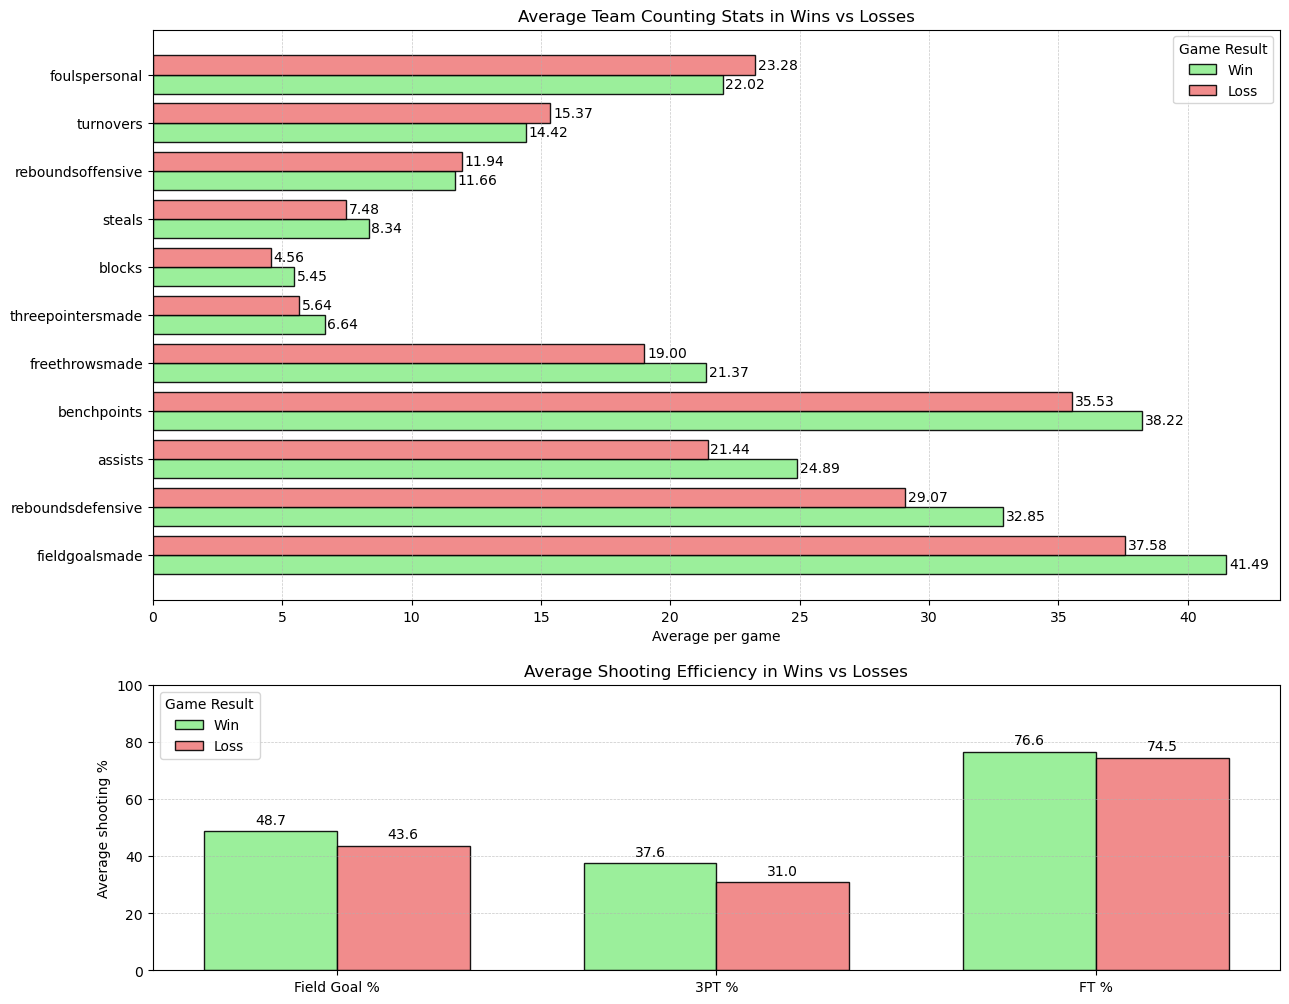

In [ ]:
# df has: win, assists, blocks, ..., fieldgoalspercentage, threepointerspercentage, freethrowspercentage
# first add a readable label
df["result"] = df["win"].map({1: "Win", 0: "Loss"})

# ----- columns -----
count_cols = [
    "assists", "blocks", "steals", "fieldgoalsmade", "threepointersmade",
    "freethrowsmade", "reboundsdefensive", "reboundsoffensive",
    "foulspersonal", "turnovers", "benchpoints"
]

pct_cols = [
    "fieldgoalspercentage", "threepointerspercentage", "freethrowspercentage"
]

# =======================
#   PREP DATA
# =======================

# 1) Counting stats: shape = stats × result (Win/Loss)
counts = df.set_index("result")[count_cols].T  # rows = stats, cols = Win/Loss
counts = counts[["Win", "Loss"]]               # fix column order

# order stats by (Win − Loss)
diff = counts["Win"] - counts["Loss"]
counts = counts.loc[diff.sort_values(ascending=False).index]

# 2) Accuracy stats: shape = stat_label × result
pct = df.set_index("result")[pct_cols].T
pct = pct[["Win", "Loss"]]
pct.index = ["Field Goal %", "3PT %", "FT %"]   # nicer labels

# =======================
#   PLOT
# =======================

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 10),
    gridspec_kw={"height_ratios": [2, 1]}
)
plt.tight_layout(h_pad=4)

colors = {"Win": "lightgreen", "Loss": "lightcoral"}

# ---------- 1) Counting stats (horizontal) ----------
y = np.arange(len(counts))
height = 0.4

for i, res in enumerate(["Win", "Loss"]):
    offset = (i - 0.5) * height
    ax1.barh(
        y + offset,
        counts[res],
        height=height,
        label=res,
        color=colors[res],
        edgecolor="black",
        alpha=0.9
    )

ax1.set_yticks(y)
ax1.set_yticklabels(counts.index)
ax1.set_xlabel("Average per game")
ax1.set_title("Average Team Counting Stats in Wins vs Losses")
ax1.legend(title="Game Result", loc="upper right")
ax1.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)

# value labels
for bars in ax1.containers:
    ax1.bar_label(bars, fmt="%.2f", padding=2)

# ---------- 2) Accuracy stats (vertical) ----------
x = np.arange(len(pct.index))
width = 0.35

for i, res in enumerate(["Win", "Loss"]):
    ax2.bar(
        x + (i - 0.5) * width,
        pct[res],
        width=width,
        label=res,
        color=colors[res],
        edgecolor="black",
        alpha=0.9
    )

ax2.set_xticks(x)
ax2.set_xticklabels(pct.index)
ax2.set_ylabel("Average shooting %")
ax2.set_title("Average Shooting Efficiency in Wins vs Losses")
ax2.legend(title="Game Result", loc="upper left")
ax2.set_ylim(0, 100)
ax2.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

for bars in ax2.containers:
    ax2.bar_label(bars, fmt="%.1f", padding=3)

plt.show()


In [ ]:
fig.savefig("visual-1.jpg", dpi=400, bbox_inches="tight")

**Insight**: Across the full dataset, we compared average team stats in games **won vs lost** to identify which performance measures most consistently separate outcomes.

* **Scoring efficiency and volume:** winning teams convert more shots and score more effectively (field goals made **41.49 vs 37.58**; 3PT% **37.6% vs 31.0%**).
* **Cleaner execution:** winning teams create better looks through teamwork and waste fewer possessions (assists **24.89 vs 21.44**; turnovers **14.42 vs 15.37**, lower is better).
* **Possession control and discipline:** winning teams secure more second chances by finishing defensive stops and reduce giveaways to opponents (defensive rebounds **32.85 vs 29.07**; personal fouls **22.02 vs 23.28**, lower is better).


### Visual 2: Given the win–loss drivers identified in Visual 1, which teams since 2024 have the highest win percentage, and how does the top team’s stat profile align with those drivers?

For Visual 2, we used SQL to focus the analysis on **recent performance** by filtering games to **year ≥ 2024** (using the date fields linked to the fact table) and then aggregating at the **team level** to calculate each team’s win rate. We then sorted teams by win rate and applied a **Top 10** constraint to keep the comparison tight and consistent. In Python, we took that ranked output and plotted it as a simple bar chart so the ordering and gaps are obvious.

For the second part of Visual 2, we ran an additional SQL slice for **one team (Thunder)**, constrained to **wins only** and **year ≥ 2024**, and computed the same set of average stats used in Visual 1. In Python, we aligned Thunder’s recent-win averages against the earlier **all-games win vs loss benchmarks** using the same columns and scaling, so the comparison stays apples-to-apples across visuals.


Below step adds a new column, winpercentage, to the teams dimension table and then populates it using the team_stats_raw fact table. The subquery calculates each team’s win rate by averaging a 1/0 win indicator (CASE WHEN win = 1 THEN 1.0 ELSE 0.0 END) and multiplying by 100, rounded to two decimals. This creates a reusable team-level KPI stored in the dimension table, so later analysis doesn’t need to recompute win % every time.

In [ ]:
%%sql
ALTER TABLE teams
ADD COLUMN winpercentage NUMERIC;
UPDATE teams t
SET winpercentage = s.win_pct
FROM (
    SELECT
        teamkey,
        ROUND(
            AVG(CASE WHEN win = 1 THEN 1.0 ELSE 0.0 END) * 100,
            2
        ) AS win_pct
    FROM team_stats_raw
    GROUP BY teamkey
) AS s
WHERE t.teamkey = s.teamkey;

Running query in 'postgresql://student@/nba_project'

43 rows affected.

++
||
++
++

Initially, we calculated win percentages using all historical seasons so every team had a long-run “average performance” baseline in the teams table. But because that dataset spans many years, the results become smoothed/normalized and can hide meaningful differences in current team strength.

So for the final analysis, we added a recency constraint by joining team_stats_raw to the dates dimension and filtering to d.year >= 2024. This produces a “current-form” win percentage (win_pct_2024_plus) and also returns a games_count to show how much recent data each team’s metric is based on, which makes the Top 10 ranking more relevant for the presentation.

In [ ]:
%%sql
SELECT
    teamkey,
    teamname,
    teamcity,
    winpercentage
FROM teams
WHERE winpercentage IS NOT NULL
ORDER BY winpercentage DESC;

Running query in 'postgresql://student@/nba_project'

43 rows affected.

teamkey,teamname,teamcity,winpercentage
42,Celtics,Boston,59.68
27,Spurs,San Antonio,58.57
28,Lakers,Minneapolis,58.52
51,Thunder,Oklahoma City,58.11
8,Nationals,Syracuse,54.91
60,Suns,Phoenix,53.29
59,Jazz,Utah,52.78
29,Heat,Miami,52.49
15,Bucks,Milwaukee,52.18
35,SuperSonics,Seattle,52.11


In [ ]:
%%sql
SELECT
    ts.teamkey,
    t.teamname,
    t.teamcity,
    ROUND(
        AVG(CASE WHEN ts.win = 1 THEN 1.0 ELSE 0.0 END) * 100,
        2
    ) AS win_pct_2024_plus,
    COUNT(*) AS games_count
FROM team_stats_raw ts
JOIN teams t ON ts.teamkey = t.teamkey
JOIN dates d ON ts.datekey = d.datekey
WHERE d.year >= 2024
GROUP BY ts.teamkey, t.teamname, t.teamcity
ORDER BY win_pct_2024_plus DESC
LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

teamkey,teamname,teamcity,win_pct_2024_plus,games_count
51,Thunder,Oklahoma City,77.23,202
42,Celtics,Boston,72.96,196
39,Cavaliers,Cleveland,63.98,186
48,Knicks,New York,63.96,197
33,Nuggets,Denver,63.16,190
62,Rockets,San Diego,60.59,170
5,Timberwolves,Minnesota,59.30,199
61,Warriors,Golden State,58.79,182
28,Lakers,Minneapolis,58.29,175
50,Clippers,LA,55.31,179


In [ ]:
top2024_result = _
df_top2024 = top2024_result.DataFrame()

# label for plotting
df_top2024["label"] = df_top2024["teamname"] + " (" + df_top2024["teamcity"] + ")"

Here, through Sql we have pulled recent, win-only performance profile for team Thunder (teamKey = 51). It joins team_stats_raw to the dates dimension so we can filter to d.year >= 2024, then further filters to wins only (ts.win = 1). Finally, it calculates the average per-game values for the same counting stats and shooting percentages used in Visual 1 (with percentages scaled to 0–100), so Thunder’s recent winning style can be compared consistently against the broader win vs loss benchmarks.

In [ ]:
%%sql
SELECT
    ROUND(AVG(ts.assists)::numeric, 2) AS assists,
    ROUND(AVG(ts.blocks) ::numeric, 2) AS blocks,
    ROUND(AVG(ts.steals) ::numeric, 2) AS steals,
    ROUND(AVG(ts.fieldGoalsMade)::numeric, 2) AS fieldGoalsMade,
    ROUND(AVG(ts.threePointersMade) ::numeric, 2) AS threePointersMade,
    ROUND(AVG(ts.freeThrowsMade) ::numeric, 2) AS freeThrowsMade,
    ROUND(AVG(ts.reboundsDefensive) ::numeric, 2) AS reboundsDefensive,
    ROUND(AVG(ts.reboundsOffensive) ::numeric, 2) AS reboundsOffensive,
    ROUND(AVG(ts.foulsPersonal) ::numeric, 2) AS foulsPersonal,
    ROUND(AVG(ts.turnovers) ::numeric, 2) AS turnovers,
    ROUND(AVG(ts.benchPoints) ::numeric, 2) AS benchPoints,
    ROUND(AVG(ts.fieldGoalsPercentage) ::numeric * 100, 2) AS fieldGoalsPercentage,
    ROUND(AVG(ts.threePointersPercentage) ::numeric * 100, 2) AS threePointersPercentage,
    ROUND(AVG(ts.freeThrowsPercentage) ::numeric * 100, 2) AS freeThrowsPercentage
FROM team_stats_raw ts
JOIN dates d ON ts.datekey = d.datekey
WHERE d.year >= 2024
  AND ts.teamkey = 51
    AND ts.win = 1;

Running query in 'postgresql://student@/nba_project'

1 rows affected.

assists,blocks,steals,fieldgoalsmade,threepointersmade,freethrowsmade,reboundsdefensive,reboundsoffensive,foulspersonal,turnovers,benchpoints,fieldgoalspercentage,threepointerspercentage,freethrowspercentage
27.17,6.10,10.28,44.71,14.12,17.74,35.02,9.89,19.35,11.81,38.73,49.53,38.12,81.71


In Python, we have prepared a single comparison table by combining **three aligned benchmarks** for the same set of team stats. It extracts Thunder’s 2024+ win-only averages (`thunder_2024`) from the SQL output, then pulls the **overall Win** and **overall Loss** rows from the earlier win/loss summary dataframe (`df`). Finally, it builds `compare_df`, which lists each stat once and shows three columns side-by-side: **Winning Avg (All Years)**, **Losing Avg (All Years)**, and **Thunder 2024+ Wins**, so the Thunder profile can be compared directly against the league-wide baselines.


In [ ]:

thunder_2024_result = _
thunder_2024 = thunder_2024_result.DataFrame().iloc[0]

# df is win/loss summary for all years
# ensure result column exists
df["result"] = df["win"].map({1: "Win", 0: "Loss"})

count_cols = [
    "assists", "blocks", "steals", "fieldgoalsmade", "threepointersmade",
    "freethrowsmade", "reboundsdefensive", "reboundsoffensive",
    "foulspersonal", "turnovers", "benchpoints"
]

# overall winning and losing averages (all years)
win_row  = df[df["result"] == "Win"].iloc[0]
loss_row = df[df["result"] == "Loss"].iloc[0]

compare_df = pd.DataFrame({
    "stat": count_cols,
    "Winning Avg (All Years)": [win_row[c]   for c in count_cols],
    "Losing Avg (All Years)":  [loss_row[c]  for c in count_cols],
    "Thunder 2024+ Wins":      [thunder_2024[c] for c in count_cols],
})

This matplotlib code creates a two-panel figure to summarize recent team performance and benchmark it against historical patterns. In the top panel, it cleans the Top-10 results by casting win percentage to numeric, sorting for a horizontal bar chart, and then plots the **Top 10 teams by win % since 2024** with value labels. In the bottom panel, it plots a side-by-side horizontal bar comparison for the same stats across three groups: **all-years winning averages**, **all-years losing averages**, and **Thunder wins since 2024**, so the Thunder’s recent winning profile can be directly compared to the league-wide benchmarks on the same scale.


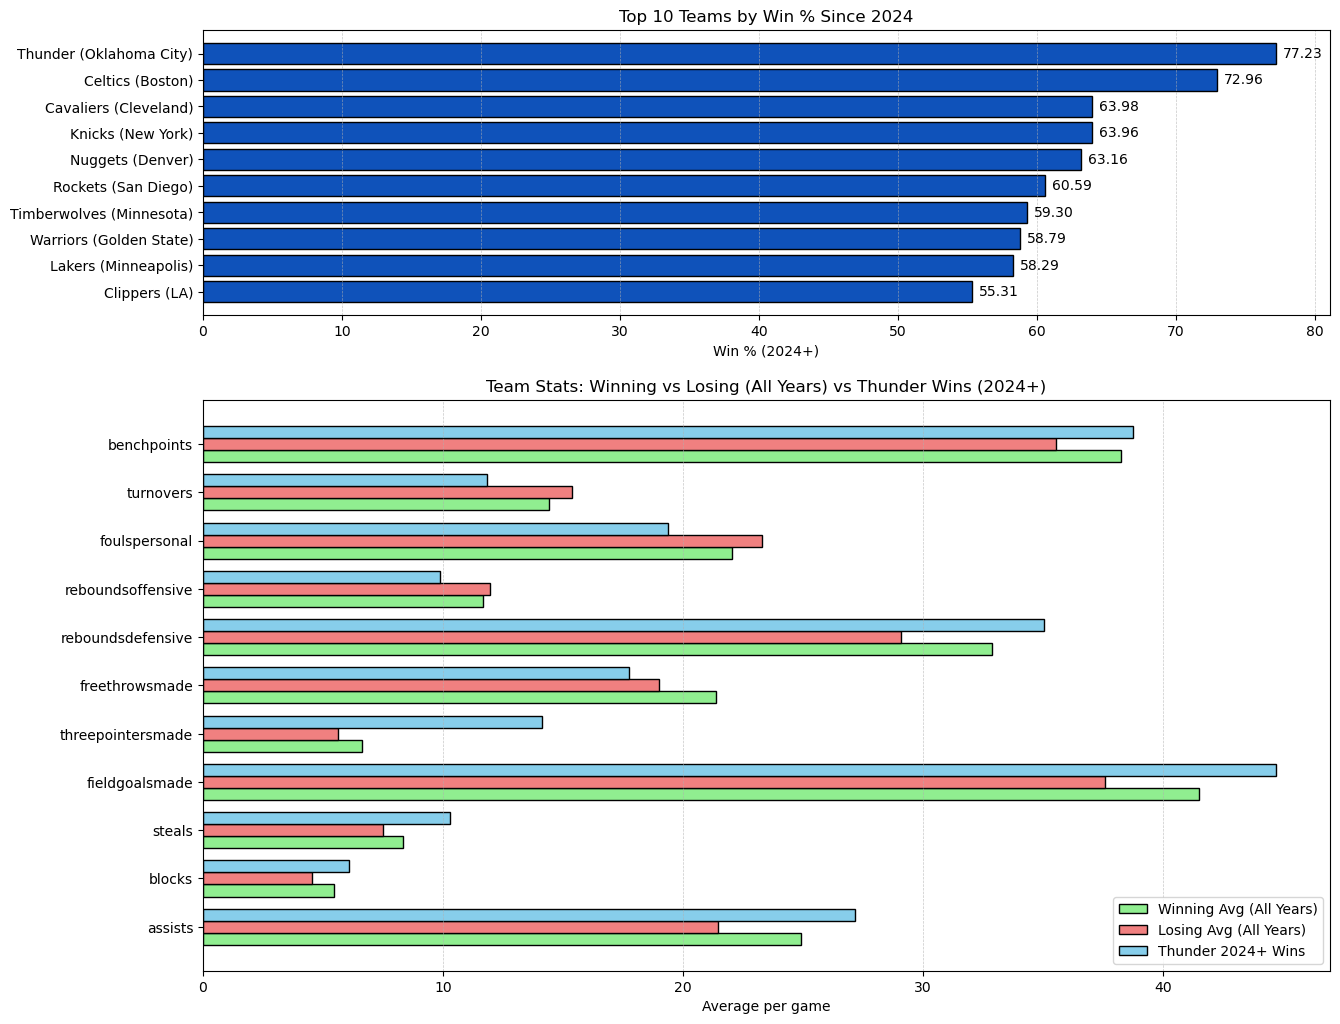

In [ ]:

# ---------- prep data for plotting ----------

# Top-10 table (copy + cast to float + sort)
df_top2024_plot = df_top2024.copy()
df_top2024_plot["win_pct_2024_plus"] = df_top2024_plot["win_pct_2024_plus"].astype(float)
df_top2024_plot = df_top2024_plot.sort_values("win_pct_2024_plus", ascending=True)

# Comparison table (copy + cast to float)
compare_df_plot = compare_df.copy()
compare_df_plot["Winning Avg (All Years)"] = compare_df_plot["Winning Avg (All Years)"].astype(float)
compare_df_plot["Losing Avg (All Years)"]  = compare_df_plot["Losing Avg (All Years)"].astype(float)
compare_df_plot["Thunder 2024+ Wins"]      = compare_df_plot["Thunder 2024+ Wins"].astype(float)

# ---------- create figure with two panels ----------

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 10),
    gridspec_kw={"height_ratios": [1, 2]}
)
plt.tight_layout(h_pad=4)

# =======================
# Top panel: Top 10 teams 2024+
# =======================

y1 = np.arange(len(df_top2024_plot))
ax1.barh(
    y1,
    df_top2024_plot["win_pct_2024_plus"],
    color="#0F52BA",
    edgecolor="black"
)

ax1.set_yticks(y1)
ax1.set_yticklabels(df_top2024_plot["label"])
ax1.set_xlabel("Win % (2024+)")
ax1.set_title("Top 10 Teams by Win % Since 2024")

for i, v in enumerate(df_top2024_plot["win_pct_2024_plus"]):
    v = float(v)
    ax1.text(v + 0.5, i, f"{v:.2f}", va="center")

ax1.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)

# =======================
# Bottom panel: 3-way comparison
# =======================

stats = compare_df_plot["stat"].tolist()
y2 = np.arange(len(stats))
height = 0.25

groups = ["Winning Avg (All Years)", "Losing Avg (All Years)", "Thunder 2024+ Wins"]
colors = {
    "Winning Avg (All Years)": "lightgreen",
    "Losing Avg (All Years)": "lightcoral",
    "Thunder 2024+ Wins": "skyblue",
}

for i, col in enumerate(groups):
    offset = (i - (len(groups) - 1) / 2) * height
    ax2.barh(
        y2 + offset,
        compare_df_plot[col],
        height=height,
        label=col,
        color=colors[col],
        edgecolor="black"
    )

ax2.set_yticks(y2)
ax2.set_yticklabels(stats)
ax2.set_xlabel("Average per game")
ax2.set_title("Team Stats: Winning vs Losing (All Years) vs Thunder Wins (2024+)")
ax2.legend(loc="lower right")
ax2.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)

plt.show()

In [ ]:
fig.savefig("visual-2.jpg", dpi=400, bbox_inches="tight")

**Insight**: Using the 2024+ window, this visual moves from the general “win vs loss” drivers to a real-world check: which teams are currently winning the most, and whether recent top teams reflect the same underlying performance patterns.

* **Recent winners are meaningfully separated:** the top teams show a clear spread in win %, with the top 2 pulling ahead of the rest of the top-10 cluster.
* **The win–loss drivers still hold in recent seasons:** top-performing teams’ win profiles align with the same levers identified earlier, mainly stronger scoring output, better creation, and better possession control.
* **Benchmarking a top team validates the model:** comparing a top team’s recent wins against the all-years win and loss baselines shows the “winning profile” is consistent, not random, which supports using these drivers as a foundation for the player-tier analysis in the next visuals.


## Player Stats Visuals

### Visual 3: What does ‘average’, ‘strong’, and ‘elite’ performance look like for key player stats when benchmarked by Guard vs Forward vs Center positions?

In SQL, we joined the player_stats_raw fact table to the players dimension using playerkey, split players into Guard/Forward/Center using the position flags, filtered out low-signal rows (numMinutes not null and numMinutes > 10), then aggregated career totals per player to compute per-minute rates (sum of stat ÷ sum of minutes, with NULLIF to avoid divide-by-zero). In Python, we converted each position result into a dataframe, kept only “real rotation” players (total_minutes > 1000), casted the stat columns to numeric, and scaled per-minute rates to per-game (multiply by 36 minutes) to standardize comparisons. Finally, for each stat and position, we calculated the 50th / 75th / 95th percentiles (dropping nulls) and plotted those percentile cutoffs as the tier bars in the chart.

Below SQL step builds the Guard-only player dataset used for Visual 3. It joins the player game-level fact table (player_stats_raw) to the players dimension, filters to guards only (p.guard = '1'), and removes low-signal rows by keeping games where minutes are present and > 10. Then it aggregates to the player level, calculating each player’s total minutes and their key stats as per-minute rates (total stat ÷ total minutes, with NULLIF to avoid divide-by-zero), rounded to 4 decimals. Finally, the result is pulled into Python as df_guard for the later per-36 scaling and percentile tier calculations.

In [ ]:
%%sql
SELECT
    p.playerkey,
    p.firstname,
    p.lastname,
    SUM(ps.numMinutes) AS total_minutes,

    ROUND(
        CAST(SUM(ps.assists) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS assists_per_min,

    ROUND(
        CAST(SUM(ps.blocks) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS blocks_per_min,

    ROUND(
        CAST(SUM(ps.steals) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS steals_per_min,

    ROUND(
        CAST(SUM(ps.fieldGoalsMade) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS fgmade_per_min,

    ROUND(
        CAST(SUM(ps.threePointersMade) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS threes_per_min,

    ROUND(
        CAST(SUM(ps.reboundsDefensive) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS dreb_per_min,

    ROUND(
        CAST(SUM(ps.reboundsOffensive) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS oreb_per_min,

    ROUND(
        CAST(SUM(ps.foulsPersonal) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS fouls_per_min,

    ROUND(
        CAST(SUM(ps.turnovers) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS tov_per_min

FROM player_stats_raw ps
JOIN players p ON ps.playerkey = p.playerkey
WHERE p.guard = '1'                 -- NOTE: string, not integer
  AND ps.numMinutes IS NOT NULL
  AND ps.numMinutes > 10
GROUP BY p.playerkey, p.firstname, p.lastname
ORDER BY total_minutes DESC;


Running query in 'postgresql://student@/nba_project'

1721 rows affected.

playerkey,firstname,lastname,total_minutes,assists_per_min,blocks_per_min,steals_per_min,fgmade_per_min,threes_per_min,dreb_per_min,oreb_per_min,fouls_per_min,tov_per_min
926,Kobe,Bryant,57480.0,0.1302,0.0137,0.0403,0.2428,0.0372,0.1138,0.0307,0.0711,0.0828
3271,Jason,Kidd,56395.0,0.2403,0.0091,0.0538,0.1240,0.0399,0.1407,0.0357,0.0526,0.0805
5707,John,Stockton,53750.0,0.3278,0.0068,0.0669,0.1466,0.0178,0.0656,0.0209,0.0828,0.0882
226,Ray,Allen,53066.0,0.0926,0.0054,0.0312,0.1834,0.0647,0.0881,0.0264,0.0628,0.0577
4105,Reggie,Miller,52565.0,0.0855,0.0063,0.0314,0.1746,0.0548,0.0692,0.0182,0.0571,0.0506
4653,Gary,Payton,52307.0,0.1874,0.0061,0.0510,0.1830,0.0244,0.0825,0.0295,0.0700,0.0637
3049,Joe,Johnson,49588.0,0.1132,0.0058,0.0249,0.1782,0.0448,0.0921,0.0246,0.0521,0.0568
1088,Vince,Carter,49556.0,0.1029,0.0190,0.0335,0.2036,0.0502,0.1089,0.0367,0.0877,0.0575
4758,Scottie,Pippen,48739.0,0.1470,0.0231,0.0552,0.1793,0.0242,0.1339,0.0518,0.0818,0.0790
3167,Michael,Jordan,48304.0,0.1378,0.0218,0.0598,0.2977,0.0151,0.1211,0.0408,0.0688,0.0718


In [ ]:
guard_result = _
df_guard = guard_result.DataFrame()


Similar to above, here we build the Forward-only player dataset for Visual 3 by joining player_stats_raw to players, filtering to forwards (p.forward = '1'), and keeping only games with numMinutes not null and > 10. we then aggregates to the player level to compute total_minutes and the same set of per-minute rates (stat totals divided by total minutes, protected by NULLIF), and loads the result into Python as df_forward.

In [ ]:
%%sql
SELECT
    p.playerkey,
    p.firstname,
    p.lastname,
    SUM(ps.numMinutes) AS total_minutes,

    ROUND(
        CAST(SUM(ps.assists) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS assists_per_min,

    ROUND(
        CAST(SUM(ps.blocks) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS blocks_per_min,

    ROUND(
        CAST(SUM(ps.steals) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS steals_per_min,

    ROUND(
        CAST(SUM(ps.fieldGoalsMade) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS fgmade_per_min,

    ROUND(
        CAST(SUM(ps.threePointersMade) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS threes_per_min,

    ROUND(
        CAST(SUM(ps.reboundsDefensive) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS dreb_per_min,

    ROUND(
        CAST(SUM(ps.reboundsOffensive) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS oreb_per_min,

    ROUND(
        CAST(SUM(ps.foulsPersonal) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS fouls_per_min,

    ROUND(
        CAST(SUM(ps.turnovers) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS tov_per_min

FROM player_stats_raw ps
JOIN players p ON ps.playerkey = p.playerkey
WHERE p.forward = '1'               -- forward flag as TEXT
  AND ps.numMinutes IS NOT NULL
  AND ps.numMinutes > 10
GROUP BY p.playerkey, p.firstname, p.lastname
ORDER BY total_minutes DESC;


Running query in 'postgresql://student@/nba_project'

1825 rows affected.

playerkey,firstname,lastname,total_minutes,assists_per_min,blocks_per_min,steals_per_min,fgmade_per_min,threes_per_min,dreb_per_min,oreb_per_min,fouls_per_min,tov_per_min
2940,LeBron,James,72455.32,0.1944,0.0204,0.0407,0.2620,0.0430,0.1722,0.0317,0.0492,0.0931
3741,Karl,Malone,62421.0,0.0938,0.0205,0.0375,0.2446,0.0015,0.2077,0.0651,0.0838,0.0812
4443,Dirk,Nowitzki,57698.0,0.0711,0.0250,0.0244,0.2194,0.0374,0.1993,0.0298,0.0710,0.0500
926,Kobe,Bryant,57480.0,0.1302,0.0137,0.0403,0.2428,0.0372,0.1138,0.0307,0.0711,0.0828
1695,Tim,Duncan,56880.0,0.0894,0.0638,0.0213,0.2189,0.0006,0.2387,0.0828,0.0717,0.0718
2104,Kevin,Garnett,55862.0,0.1075,0.0405,0.0373,0.2107,0.0034,0.2310,0.0639,0.0729,0.0645
4736,Paul,Pierce,52482.0,0.1032,0.0166,0.0379,0.1884,0.0469,0.1426,0.0236,0.0815,0.0780
3049,Joe,Johnson,49588.0,0.1132,0.0058,0.0249,0.1782,0.0448,0.0921,0.0246,0.0521,0.0568
1088,Vince,Carter,49556.0,0.1029,0.0190,0.0335,0.2036,0.0502,0.1089,0.0367,0.0877,0.0575
2567,Elvin,Hayes,48811.0,0.0476,0.0238,0.0088,0.2175,0.0001,0.0493,0.0202,0.0846,0.0145


In [ ]:
forward_result = _
df_forward = forward_result.DataFrame()

Again, below SQL builds the Center-only player dataset for Visual 3 by joining player_stats_raw to players, filtering to centers (p.center = '1'), and keeping only games with numMinutes not null and > 10. It aggregates to the player level to compute total_minutes and the same per-minute rates, and loads the result into Python as df_center.

In [ ]:
%%sql
SELECT
    p.playerkey,
    p.firstname,
    p.lastname,
    SUM(ps.numMinutes) AS total_minutes,

    ROUND(
        CAST(SUM(ps.assists) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS assists_per_min,

    ROUND(
        CAST(SUM(ps.blocks) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS blocks_per_min,

    ROUND(
        CAST(SUM(ps.steals) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS steals_per_min,

    ROUND(
        CAST(SUM(ps.fieldGoalsMade) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS fgmade_per_min,

    ROUND(
        CAST(SUM(ps.threePointersMade) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS threes_per_min,

    ROUND(
        CAST(SUM(ps.reboundsDefensive) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS dreb_per_min,

    ROUND(
        CAST(SUM(ps.reboundsOffensive) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS oreb_per_min,

    ROUND(
        CAST(SUM(ps.foulsPersonal) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS fouls_per_min,

    ROUND(
        CAST(SUM(ps.turnovers) AS numeric)
        / NULLIF(CAST(SUM(ps.numMinutes) AS numeric), 0),
        4
    ) AS tov_per_min

FROM player_stats_raw ps
JOIN players p ON ps.playerkey = p.playerkey
WHERE p.center = '1'               -- center flag as TEXT
  AND ps.numMinutes IS NOT NULL
  AND ps.numMinutes > 10
GROUP BY p.playerkey, p.firstname, p.lastname
ORDER BY total_minutes DESC;

Running query in 'postgresql://student@/nba_project'

747 rows affected.

playerkey,firstname,lastname,total_minutes,assists_per_min,blocks_per_min,steals_per_min,fgmade_per_min,threes_per_min,dreb_per_min,oreb_per_min,fouls_per_min,tov_per_min
130,Kareem,Abdul-Jabbar,64853.0,0.0968,0.0535,0.0176,0.2741,0.0000,0.1185,0.0389,0.0822,0.0424
1695,Tim,Duncan,56880.0,0.0894,0.0638,0.0213,0.2189,0.0006,0.2387,0.0828,0.0717,0.0718
1126,Wilt,Chamberlain,53354.0,0.0952,0.0000,0.0000,0.2567,0.0000,0.0000,0.0000,0.0447,0.0000
4605,Robert,Parish,51079.0,0.0466,0.0483,0.0237,0.2085,0.0000,0.1952,0.0888,0.0972,0.0608
4475,Shaquille,O'Neal,50005.0,0.0726,0.0642,0.0173,0.2696,0.0000,0.2128,0.1023,0.0997,0.0799
4511,Hakeem,Olajuwon,49750.0,0.0706,0.0864,0.0484,0.2462,0.0006,0.2182,0.0905,0.0993,0.0822
3742,Moses,Malone,47632.0,0.0397,0.0363,0.0221,0.2084,0.0002,0.1551,0.1099,0.0663,0.0643
2122,Pau,Gasol,46602.0,0.0970,0.0480,0.0151,0.1940,0.0043,0.2007,0.0757,0.0666,0.0641
5079,Clifford,Robinson,46211.0,0.0727,0.0330,0.0335,0.1719,0.0290,0.1051,0.0441,0.1012,0.0593
1852,Patrick,Ewing,45375.0,0.0546,0.0702,0.0277,0.2375,0.0006,0.2183,0.0676,0.0997,0.0851


In [ ]:
center_result = _
df_center = center_result.DataFrame()

Below python codes organizes the three position datasets (Guard/Forward/Center) into a single structure and prepares them for percentile benchmarking. It applies a key constraint by keeping only “real rotation” players with total_minutes > 1000, then converts the per-minute stat columns into numeric and scales them to per-36 minutes (per-minute × 36) so players can be compared on a consistent playing-time basis across positions.

In [ ]:

# Base dataframes by position
pos_dfs = {
    "Guard":   df_guard.copy(),
    "Forward": df_forward.copy(),
    "Center":  df_center.copy(),
}

positions = ["Guard", "Forward", "Center"]

# Focus stats (per-minute columns from SQL)
stat_cols = [
    "assists_per_min",
    "threes_per_min",   # 3P made
    "blocks_per_min",
    "fgmade_per_min",
    "dreb_per_min",     # defensive rebounds
    "oreb_per_min",     # offensive rebounds
]

stat_labels = {
    "assists_per_min": "Assists",
    "threes_per_min":  "3P Made",
    "blocks_per_min":  "Blocks",
    "fgmade_per_min": "FGmade",
    "dreb_per_min":    "Def. Rebounds",
    "oreb_per_min":    "Off. Rebounds",
}

# Only real-rotation players
min_minutes = 1000
per_minutes_for_visual = 36.0  # "per 36 minutes game" assumption

# Clean and derive per-36 for each position
for pos, df in pos_dfs.items():
    # 1) filter on total_minutes
    df = df[df["total_minutes"] > min_minutes].copy()

    # 2) ensure numeric and create per-36 columns
    for stat in stat_cols:
        if stat not in df.columns:
            continue

        df[stat] = pd.to_numeric(df[stat], errors="coerce").astype(float)
        per36_col = stat.replace("_per_min", "_per36")
        df[per36_col] = df[stat] * per_minutes_for_visual

    pos_dfs[pos] = df


Here, we calculates the 50th, 75th, and 95th percentile cutoffs for each per-36 stat within each position group. For every stat and position, it pulls the non-null per-36 values after filtering (minutes > 1000) and uses np.percentile to store the tier thresholds, falling back to NaN if a position has no remaining players for that stat.

In [ ]:
percentiles = [50, 75, 95]

# quantiles[stat][pos][p] -> value
quantiles = {stat: {pos: {} for pos in positions} for stat in stat_cols}

for stat in stat_cols:
    per36_col = stat.replace("_per_min", "_per36")
    for pos in positions:
        df_pos = pos_dfs[pos]
        if per36_col not in df_pos.columns:
            continue

        vals = df_pos[per36_col].dropna().values
        if len(vals) == 0:
            # no players after filtering
            for p in percentiles:
                quantiles[stat][pos][p] = np.nan
            continue

        for p in percentiles:
            q_val = np.percentile(vals, p)
            quantiles[stat][pos][p] = float(q_val)


Below plot turns the percentile thresholds into the Visual 3 chart. It creates one subplot per stat, and for each position (Guard/Forward/Center) it plots three side-by-side bars representing the 50th, 75th, and 95th percentile per-36 minutes values computed earlier. The bars are labeled with the numeric cutoff values, share a common x-axis for positions, and the title clearly states the two key constraints used in the benchmarking: players with > 1000 total minutes and stats scaled to per 36 minutes.

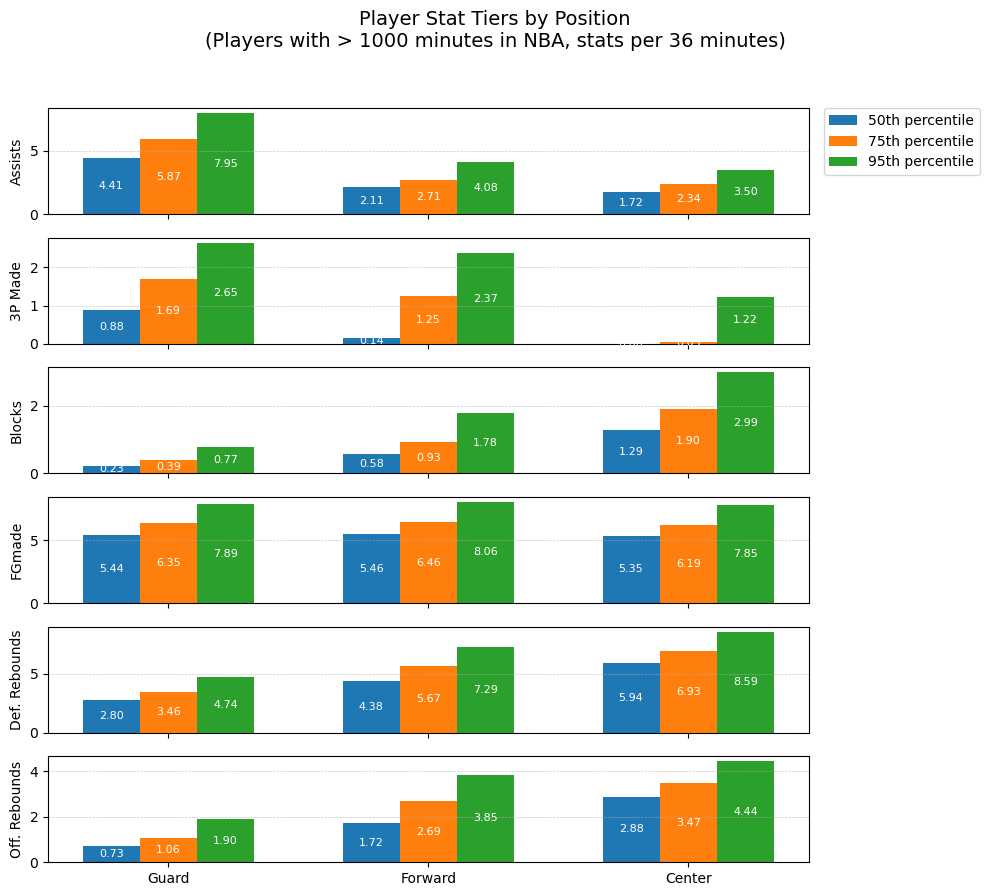

In [ ]:
n_stats = len(stat_cols)
x = np.arange(len(positions))   # positions on x-axis
bar_width = 0.22

fig, axes = plt.subplots(
    n_stats, 1,
    figsize=(10, 1.5 * n_stats),
    sharex=True
)

# Ensure axes is an array
if n_stats == 1:
    axes = np.array([axes])

for i, stat in enumerate(stat_cols):
    ax = axes[i]
    label = stat_labels[stat]
    per36_label = f"{label}"

    # heights for each percentile
    heights_50 = [quantiles[stat][pos][50] for pos in positions]
    heights_75 = [quantiles[stat][pos][75] for pos in positions]
    heights_95 = [quantiles[stat][pos][95] for pos in positions]

    # bar positions (centered around x)
    bars_50 = ax.bar(
        x - bar_width,
        heights_50,
        width=bar_width,
        label="50th percentile"
    )
    bars_75 = ax.bar(
        x,
        heights_75,
        width=bar_width,
        label="75th percentile"
    )
    bars_95 = ax.bar(
        x + bar_width,
        heights_95,
        width=bar_width,
        label="95th percentile"
    )

    # Add white text labels inside the bars
    for bars, vals in zip(
        [bars_50, bars_75, bars_95],
        [heights_50, heights_75, heights_95]
    ):
        ax.bar_label(
            bars,
            labels=[f"{v:.2f}" for v in vals],
            label_type="center",   # put text in middle of bar
            color="white",
            fontsize=8
        )

    ax.set_ylabel(per36_label)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

    if i == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# x-axis: position labels on the last subplot
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(positions)

fig.suptitle(
    f"Player Stat Tiers by Position\n"
    f"(Players with > {min_minutes} minutes in NBA, stats per 36 minutes)",
    y=0.99,
    fontsize=14
)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
fig.savefig("visual-3.jpg", dpi=400, bbox_inches="tight")

**Insight**: Using players with **> 1000 total minutes** and standardizing stats to **per 36 minutes**, this visual sets position-specific benchmarks for what “typical”, “strong”, and “elite” performance looks like (50th, 75th, 95th percentiles).

* **Guards are differentiated by creation and spacing:** assists jump from **4.41 (50th)** to **7.95 (95th)**, and 3P made rises from **0.88 (50th)** to **2.65 (95th)**; these are the clearest guard-specific separators.
* **Centers are differentiated by rim impact and rebounding:** blocks move from **1.29 (50th)** to **2.99 (95th)**, defensive rebounds from **5.94 to 8.59**, and offensive rebounds from **2.88 to 4.44**; the “elite” center threshold is materially higher than other positions on these stats.
* **Forwards sit between guards and centers, with balance as the signal:** forwards show strong rebounding thresholds (DREB **4.38 to 7.29**, OREB **1.72 to 3.85**) while still contributing to shooting and playmaking more than centers; this supports treating forwards as a hybrid role when defining tier cutoffs.


### Visual 4: Relative to historical, position-based performance benchmarks, where do today’s active players rank by tier (elite/strong/average/developing) across Guards, Forwards, and Centers?

Yes, Visual 4 inherits the same constraints, and they matter for why the tiers are credible.

For Visual 4, we start from the same **position datasets** built from `player_stats_raw`, where we already filtered out noisy game rows by requiring **`numMinutes` not null and `numMinutes > 10`** before aggregating, so per-minute rates aren’t distorted by tiny appearances. After aggregating to the player level, we apply the “rotation player” constraint **`total_minutes > 1000`**, then convert per-minute rates into **per-36 minutes game** so every player is compared on a consistent playing-time basis. Next, we restrict to **currently active players** by keeping only players who appear in **2024/2025**, so we’re tiering the current talent pool (not historical/retired players). Using the position-specific per-36 distributions, we compute percentile cutoffs and assign each active player an **overall tier (Low/50/75/95)** based on how strongly they hit top benchmarks in **position-relevant stats**, then we summarize the results as counts by position in the stacked bar chart.


This SQL step identifies the **currently active player pool** based on game participation. It joins `player_stats_raw` to the `dates` dimension and selects **distinct playerKey values** for players who recorded at least one game in **2024 or 2025**. The output becomes the filter list used in Python so Visual 4 tiers only reflect players who are active in the most recent seasons.

In [ ]:
%%sql
-- players who have at least one game in 2024 or 2025
SELECT DISTINCT ps.playerkey
FROM player_stats_raw ps
JOIN dates d ON ps.datekey = d.datekey
WHERE d.year IN (2024, 2025)
ORDER BY ps.playerkey;


Running query in 'postgresql://student@/nba_project'

904 rows affected.

playerkey
9
10
13
16
17
19
23
25
32
33


This Python step runs the “active players” SQL query, converts the results into a dataframe, and then stores the distinct `playerkey` values in a Python `set` for fast filtering. The final `len(active_player_ids)` line is a quick check to confirm how many unique active players (2024/2025 participants) will be carried into the tiering and visualization in Visual 4.


In [ ]:
active_players_sql = %sql \
    SELECT DISTINCT ps.playerkey \
    FROM player_stats_raw ps \
    JOIN dates d ON ps.datekey = d.datekey \
    WHERE d.year IN (2024, 2025) \
    ORDER BY ps.playerkey;

active_players_df = active_players_sql.DataFrame()
active_player_ids = set(active_players_df["playerkey"])
len(active_player_ids)


Running query in 'postgresql://student@/nba_project'

904 rows affected.

904

This step filters each position dataframe down to **only active players**, using the `active_player_ids` set created from the 2024/2025 SQL query. It creates three new dataframes (`guard_active`, `forward_active`, `center_active`) that keep the same player-level per-minute metrics and constraints already applied earlier, but remove players who are not currently active. The `.shape` output is used as a quick validation to see how many active players remain in each position group after filtering.


In [ ]:
guard_active   = df_guard[df_guard["playerkey"].isin(active_player_ids)].copy()
forward_active = df_forward[df_forward["playerkey"].isin(active_player_ids)].copy()
center_active  = df_center[df_center["playerkey"].isin(active_player_ids)].copy()

guard_active.shape, forward_active.shape, center_active.shape


((174, 13), (211, 13), (77, 13))

Next, we defined the per-minute stats that drive the tiering model and built the position-specific benchmark thresholds that the tier logic relies on. We calculated the **50th/75th/95th percentile cutoffs** for each stat separately for Guards, Forwards, and Centers. This produced a structured set of thresholds (`bulk_thresholds`) that lets us evaluate active players against the correct historical baseline for their position.


In [ ]:
stat_cols = [
    "assists_per_min",
    "threes_per_min",       # 3P made
    "blocks_per_min",
    "fgmade_per_min",       # field goals made
    "dreb_per_min",         # defensive rebounds
    "oreb_per_min",         # offensive rebounds
    "fouls_per_min",
    "tov_per_min"           # turnovers
]

# same minutes cut you used when you built the bulk percentiles before
min_minutes = 1000

In [ ]:

def compute_bulk_thresholds(df_full, stat_columns, min_minutes):
    # only use players with decent sample size
    df_base = df_full[df_full["total_minutes"] >= min_minutes].copy()

    thresholds = {}
    for stat in stat_columns:
        # force numeric float; turn any bad values into NaN
        s = pd.to_numeric(df_base[stat], errors="coerce").astype(float)
        thresholds[stat] = {
            50: s.quantile(0.50),
            75: s.quantile(0.75),
            95: s.quantile(0.95),
        }
    return thresholds

bulk_thresholds = {
    "Guard":   compute_bulk_thresholds(df_guard,   stat_cols, min_minutes),
    "Forward": compute_bulk_thresholds(df_forward, stat_cols, min_minutes),
    "Center":  compute_bulk_thresholds(df_center,  stat_cols, min_minutes),
}

Here, we applied the position-specific percentile thresholds to the **active-player** datasets to convert raw per-minute stats into simple tier labels. For each stat, the function creates a new “percentile tier” column and classifies every player as **95 / 75 / 50 / Low** by comparing their value against the precomputed cutoffs for that position (with non-numeric values coerced to NaN). This produces a consistent set of tier columns for guards, forwards, and centers that later roll up into the final overall tier and stacked-bar summary.


In [ ]:

def apply_tiers(df_active, position_label, stat_columns, bulk_thr):
    thr_pos = bulk_thr[position_label]

    for stat in stat_columns:
        pct_col = stat.replace("_per_min", "") + "_pctile"
        t50 = thr_pos[stat][50]
        t75 = thr_pos[stat][75]
        t95 = thr_pos[stat][95]

        def classify(val):
            if pd.isna(val):
                return np.nan
            if val >= t95:
                return 95
            elif val >= t75:
                return 75
            elif val >= t50:
                return 50
            else:
                return "Low"

        df_active[pct_col] = pd.to_numeric(df_active[stat], errors="coerce").astype(float).apply(classify)

    return df_active

guard_active   = apply_tiers(guard_active,   "Guard",   stat_cols, bulk_thresholds)
forward_active = apply_tiers(forward_active, "Forward", stat_cols, bulk_thresholds)
center_active  = apply_tiers(center_active,  "Center",  stat_cols, bulk_thresholds)


Next, we convert the stat-specific tiers into one overall tier per player using a position-based counting rule.

**Key stats by position**
Guard: assists, threes, FG made; Forward: FG made, DREB, OREB; Center: DREB, blocks, OREB, FG made; all remaining tiered stats are treated as “other”.

**Counts we compute per player**
We compute key_95 and other_95 (how many key/other stats are at 95); key_75p and other_75p (how many key/other stats are at 75 or 95); key_50p (how many key stats are at 50+).

**Tier rules (applied in order)**
Overall 95: key_95 ≥ 2, or (key_95 = 1 and other_95 ≥ 2); otherwise overall 75: key_75p ≥ 2, or (key_75p ≥ 1 and other_75p ≥ 2); otherwise overall 50: key_50p ≥ 1; otherwise Low; this is reasonable because it benchmarks within position, prioritizes role-defining stats, and requires multiple strong signals for higher tiers.

Then, we used the defined overall-tier logic to evaluate each active player and assign a single tier label, creating updated position-specific dataframes for Guards, Forwards, and Centers. This step reads the stat-level percentile tiers already computed for each player, applies the role-based “key vs other” rules, and writes the final classification into overall_pctile (Low/50/75/95).

In [ ]:

def assign_overall_tier(df, position_label, out_col="overall_pctile"):
    """
    Simple tier logic based on counting 95 / 75 / 50 percentiles.

    position_label: "Guard", "Forward", or "Center"
    df: dataframe that already has *_pctile columns.
    """

    # 1) Which stats are key for each position
    config = {
        "Guard": {
            # main / key stats
            "key":   ["assists_pctile", "threes_pctile", "fgmade_pctile"],
            # other stats we still consider
            "other": ["blocks_pctile", "dreb_pctile", "oreb_pctile",
                      "fouls_pctile", "tov_pctile"],
        },
        "Forward": {
            "key":   ["fgmade_pctile", "dreb_pctile", "oreb_pctile"],
            "other": ["assists_pctile", "threes_pctile", "blocks_pctile",
                      "fouls_pctile", "tov_pctile"],
        },
        "Center": {
            "key":   ["dreb_pctile", "blocks_pctile", "oreb_pctile", "fgmade_pctile"],
            "other": ["assists_pctile", "threes_pctile",
                      "fouls_pctile", "tov_pctile"],
        },
    }

    key_cols   = config[position_label]["key"]
    other_cols = config[position_label]["other"]

    df = df.copy()

    # Make sure we don't blow up if some columns are missing
    key_cols   = [c for c in key_cols   if c in df.columns]
    other_cols = [c for c in other_cols if c in df.columns]

    # Helper to count how many cols hit a condition per row
    def count_eq(cols, value):
        if not cols:
            return pd.Series(0, index=df.index)
        return (df[cols] == value).sum(axis=1)

    def count_ge(cols, min_val):
        if not cols:
            return pd.Series(0, index=df.index)
        return df[cols].isin([v for v in [50, 75, 95] if v >= min_val]).sum(axis=1)

    # 2) Counts for 95 and 75+ on key vs other stats
    key_95   = count_eq(key_cols, 95)
    other_95 = count_eq(other_cols, 95)

    key_75p   = count_ge(key_cols, 75)     # 75 or 95
    other_75p = count_ge(other_cols, 75)

    key_50p = count_ge(key_cols, 50)       # 50, 75, or 95

    # 3) Tier Rules

    # 95-tier:
    cond_95 = (key_95 >= 2) | ((key_95 == 1) & (other_95 >= 2))

    # 75-tier (only for players not already 95):
    cond_75 = (~cond_95) & (
        (key_75p >= 2) |
        ((key_75p >= 1) & (other_75p >= 2))
    )

    # 50-tier (only for players not already 95 or 75):
    cond_50 = (~cond_95) & (~cond_75) & (key_50p >= 1)

    # Default to "Low", then overwrite where conditions match
    overall = pd.Series("Low", index=df.index, dtype=object)
    overall[cond_50] = 50
    overall[cond_75] = 75
    overall[cond_95] = 95

    df[out_col] = overall
    return df

In [ ]:
guard_active   = assign_overall_tier(guard_active,   "Guard")
forward_active = assign_overall_tier(forward_active, "Forward")
center_active  = assign_overall_tier(center_active,  "Center")

Here, we ran a validation check to confirm how many active players fall into each overall tier by position. This function counts the frequency of `overall_pctile` values (95, 75, 50, Low) separately for Guards, Forwards, and Centers, then combines those counts into a single summary table. Finally, it adds an optional TOTAL row to confirm the overall distribution sums correctly before plotting the final stacked bar chart.


In [ ]:

def tier_summary(guard_active, forward_active, center_active):
    frames = {
        "Guard":   guard_active,
        "Forward": forward_active,
        "Center":  center_active,
    }

    rows = []
    for pos, df in frames.items():
        vc = df["overall_pctile"].value_counts()
        rows.append({
            "position": pos,
            "95":  int(vc.get(95, 0)),
            "75":  int(vc.get(75, 0)),
            "50":  int(vc.get(50, 0)),
            "Low": int(vc.get("Low", 0)),
        })

    summary = pd.DataFrame(rows).set_index("position")
    summary.loc["TOTAL"] = summary.sum()   # optional total row
    return summary

summary_table = tier_summary(guard_active, forward_active, center_active)
summary_table


,95,75,50,Low
position,,,,
Guard,8,97,65,4
Forward,14,73,95,29
Center,12,37,24,4
TOTAL,34,207,184,37


Next, we prepared the final dataset for Visual 4 by adding a position label to each active-player dataframe (Guard, Forward, Center) and combining them into one table. We then counted how many active players in each position fall into each overall tier, keeping the tier order Low → 50 → 75 → 95 so the stacked bars build from worst to best. Finally, we plotted a stacked bar chart with segment labels showing the exact player counts, and the title explicitly carries forward the key constraint that only players with at least 1000 total minutes are included.

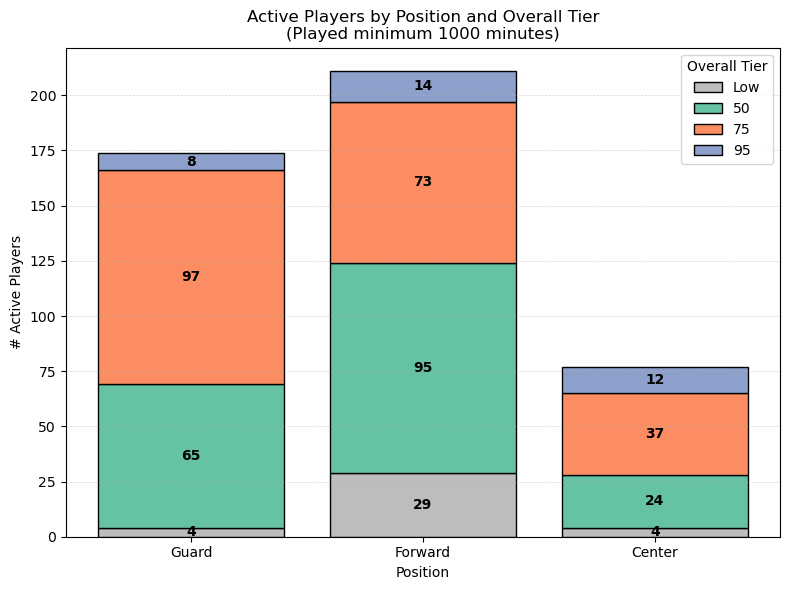

In [ ]:

# ---------- 1) Combine the three active dataframes with a position flag ----------
guard_plot   = guard_active.copy()
forward_plot = forward_active.copy()
center_plot  = center_active.copy()

guard_plot["position"]   = "Guard"
forward_plot["position"] = "Forward"
center_plot["position"]  = "Center"

df_all = pd.concat([guard_plot, forward_plot, center_plot], ignore_index=True)

# Include Low + 50 / 75 / 95
positions  = ["Guard", "Forward", "Center"]
tier_order = ["Low", 50, 75, 95]   # order from worst to best

# Build counts for overall tiers
counts = (
    df_all[df_all["overall_pctile"].isin(tier_order)]
      .groupby(["position", "overall_pctile"])
      .size()
      .unstack(fill_value=0)
      .reindex(index=positions, columns=tier_order, fill_value=0)
)

x = np.arange(len(positions))
fig, ax = plt.subplots(figsize=(8, 6))

bottom = np.zeros(len(positions))

# Colors: Low, 50, 75, 95
colors = ["#bdbdbd", "#66c2a5", "#fc8d62", "#8da0cb"]

for tier, color in zip(tier_order, colors):
    vals = counts[tier].values
    bars = ax.bar(x, vals, bottom=bottom, label=str(tier),
                  color=color, edgecolor="black")

    # label each segment with count
    for bar, v in zip(bars, vals):
        if v > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                str(int(v)),
                ha="center", va="center",
                color="black", fontsize=10, fontweight="bold"
            )

    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(positions)
ax.set_ylabel("# Active Players")
ax.set_xlabel("Position")
ax.set_title(
    "Active Players by Position and Overall Tier\n"
    "(Played minimum 1000 minutes)"
    )
ax.legend(title="Overall Tier", loc="upper right")
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()


**Insight**: This visual shows the **current distribution of active, high-minute players (≥ 1000 minutes)** across the overall tiers, using position-specific benchmarks built from historical performance.

* **Elite (95) talent is a small slice in every position:** Guards have **8**, Forwards **14**, Centers **12**; this confirms the model is selective and that “top-tier” performance is scarce.
* **Forwards represent the deepest pool overall:** they have the largest total count across tiers (notably **95 players at tier 50** and **73 at tier 75**), which suggests more supply and more options for filling roles at solid-to-strong levels.
* **This tiering becomes a practical recruiting and contract screen:** instead of comparing players on raw totals, it groups active players into clear buckets relative to position expectations, helping teams focus scouting and compensation discussions on the smaller set of players consistently hitting top benchmarks (75/95), while separating them from “average” and “developing” profiles.


In [ ]:
fig.savefig("visual-4.jpg", dpi=400, bbox_inches="tight")

## Dependency of teams on superstars

In [ ]:
%load_ext sql
%sql postgresql+psycopg2://student@nba_project

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

engine = create_engine("postgresql+psycopg2://student@nba_project")

superstars = {
    893: "Michael Jordan",
    2940: "LeBron James",
    130: "Kobe Bryant",
    3741: "Kevin Durant",
    1495: "Tim Duncan",
}

keys = tuple(superstars.keys())

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


RuntimeError: (psycopg2.OperationalError) could not translate host name "nba_project" to address: Temporary failure in name resolution

(Background on this error at: https://sqlalche.me/e/20/e3q8)


Comment: Initializes the SQL extension and database connection, imports required analysis and visualization libraries, and defines a mapping of selected NBA superstar player IDs to names for use in subsequent queries and analysis

In [ ]:
import os
print(os.environ.get("DATABASE_URL"))

None


Comment: Checks whether the DATABASE_URL environment variable is set and prints its value to confirm database connection configuration

In [ ]:
engine = create_engine("postgresql+psycopg2://student@/nba_project")

Comment: Creates a SQLAlchemy engine that establishes a connection to the local nba_project PostgreSQL database using the student user

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("postgresql+psycopg2://student@/nba_project")

pd.read_sql("SELECT current_database(), current_user;", engine)

,current_database,current_user
0,nba_project,student


Comment: Imports required libraries, establishes a database connection, and runs a simple SQL query to verify the active database and user

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("postgresql+psycopg2://student@/nba_project")

pd.read_sql("SELECT 1 AS ok;", engine)

,ok
0,1


Comment: Creates a database connection and executes a minimal test query to confirm the connection is working properly

In [ ]:
pd.read_sql("""
SELECT tablename AS table_name
FROM pg_catalog.pg_tables
WHERE schemaname = 'public'
ORDER BY tablename;
""", engine)

,table_name
0,dates
1,games
2,player_stats_raw
3,players
4,players_raw
5,team_stats_raw
6,teams


Comment: Queries the PostgreSQL system catalog to list all tables in the public schema, confirming available datasets in the database

In [ ]:
from sqlalchemy import text

q = text("""
SELECT tablename AS table_name
FROM pg_catalog.pg_tables
WHERE schemaname = 'public'
  AND tablename ILIKE '%team%'
ORDER BY tablename;
""")

with engine.connect() as conn:
    df_team_tables = pd.read_sql(q, conn)

df_team_tables

,table_name
0,team_stats_raw
1,teams


Comment: Uses a parameterized SQL query to retrieve and display all public-schema tables with “team” in their name, helping identify team-related datasets in the database

In [ ]:
%%sql
WITH superstar_games AS (
    SELECT DISTINCT
        ps.gamekey,
        ps.teamkey,
        ps.playerkey,
        1 AS with_star
    FROM player_stats_raw ps
    WHERE ps.playerkey IN (893, 2940, 130, 3741, 1495)
)
SELECT *
FROM superstar_games
LIMIT 10;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

gamekey,teamkey,playerkey,with_star
49,39,2940,1
57,39,2940,1
57,58,893,1
59,39,2940,1
62,58,893,1
74,28,2940,1
77,39,2940,1
100,58,893,1
112,28,2940,1
131,39,2940,1


Comment: Creates a CTE to identify games where selected superstar players appeared, flagging those team–game combinations for downstream analysis

In [ ]:
%%sql

WITH star_games AS (
    SELECT DISTINCT
        ps.gamekey,
        ps.teamkey,
        ps.playerkey,
        1 AS with_star
    FROM player_stats_raw ps
    WHERE ps.playerkey IN (893, 2940, 130, 3741, 1495)
),

team_games AS (
    SELECT DISTINCT
        ts.gamekey,
        ts.teamkey,
        ts.win
    FROM team_stats_raw ts
)

SELECT
    tg.gamekey,
    tg.teamkey,
    sg.playerkey,
    COALESCE(sg.with_star, 0) AS with_star,
    tg.win
FROM team_games tg
LEFT JOIN star_games sg
    ON tg.gamekey = sg.gamekey
   AND tg.teamkey = sg.teamkey
ORDER BY sg.playerkey NULLS LAST, tg.gamekey
LIMIT 20;

Running query in 'postgresql://student@/nba_project'

20 rows affected.

gamekey,teamkey,playerkey,with_star,win
2822,15,130,1,1
2883,15,130,1,1
3228,15,130,1,0
3479,15,130,1,1
3667,28,130,1,1
3809,28,130,1,1
4137,28,130,1,0
5709,15,130,1,1
6325,28,130,1,1
6848,28,130,1,0


Comment: Builds CTEs for superstar appearances and team game results, then joins them to label each team–game as played with or without a superstar and include the game outcome

In [ ]:
%%sql

WITH star_games AS (
    SELECT DISTINCT
        ps.gamekey,
        ps.teamkey,
        ps.playerkey,
        1 AS with_star
    FROM player_stats_raw ps
    WHERE ps.playerkey IN (893, 2940, 130, 3741, 1495)
),

team_games AS (
    SELECT DISTINCT
        ts.gamekey,
        ts.teamkey,
        ts.win
    FROM team_stats_raw ts
),

-- Build a "player team list" so we only compare games for that player's teams
player_teams AS (
    SELECT DISTINCT playerkey, teamkey
    FROM player_stats_raw
    WHERE playerkey IN (893, 2940, 130, 3741, 1495)
),

combined AS (
    SELECT
        pt.playerkey,
        tg.teamkey,
        tg.gamekey,
        COALESCE(sg.with_star, 0) AS with_star,
        tg.win
    FROM player_teams pt
    JOIN team_games tg
      ON tg.teamkey = pt.teamkey
    LEFT JOIN star_games sg
      ON sg.gamekey = tg.gamekey
     AND sg.teamkey = tg.teamkey
     AND sg.playerkey = pt.playerkey
)

SELECT
    playerkey,
    with_star,
    COUNT(*) AS games,
    ROUND(AVG(win::numeric), 3) AS win_pct
FROM combined
GROUP BY playerkey, with_star
ORDER BY playerkey, with_star DESC;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

playerkey,with_star,games,win_pct
130,1,1797,0.683
130,0,10180,0.536
893,1,850,0.442
893,0,30563,0.498
1495,1,6,0.333
1495,0,11427,0.533
2940,1,2021,0.625
2940,0,13144,0.523
3741,1,1680,0.629
3741,0,9773,0.551


Comment: Constructs player-specific team game histories and compares win percentages for each superstar’s teams in games played with versus without that player

In [ ]:
%%sql

WITH stars(playerkey, player_name) AS (
  VALUES
    (893,  'Michael Jordan'),
    (2940, 'LeBron James'),
    (130,  'Kobe Bryant'),
    (3741, 'Kevin Durant'),
    (1495, 'Tim Duncan')
),

star_games AS (
    SELECT DISTINCT ps.gamekey, ps.teamkey, ps.playerkey, 1 AS with_star
    FROM player_stats_raw ps
    WHERE ps.playerkey IN (893, 2940, 130, 3741, 1495)
),

team_games AS (
    SELECT DISTINCT ts.gamekey, ts.teamkey, ts.win
    FROM team_stats_raw ts
),

player_teams AS (
    SELECT DISTINCT playerkey, teamkey
    FROM player_stats_raw
    WHERE playerkey IN (893, 2940, 130, 3741, 1495)
),

combined AS (
    SELECT
        pt.playerkey,
        tg.teamkey,
        tg.gamekey,
        COALESCE(sg.with_star, 0) AS with_star,
        tg.win
    FROM player_teams pt
    JOIN team_games tg
      ON tg.teamkey = pt.teamkey
    LEFT JOIN star_games sg
      ON sg.gamekey = tg.gamekey
     AND sg.teamkey = tg.teamkey
     AND sg.playerkey = pt.playerkey
)

SELECT
    s.player_name,
    c.with_star,
    COUNT(*) AS games,
    ROUND(AVG(c.win::numeric), 3) AS win_pct
FROM combined c
JOIN stars s ON s.playerkey = c.playerkey
GROUP BY s.player_name, c.with_star
ORDER BY s.player_name, c.with_star DESC;

Running query in 'postgresql://student@/nba_project'

10 rows affected.

player_name,with_star,games,win_pct
Kevin Durant,1,1680,0.629
Kevin Durant,0,9773,0.551
Kobe Bryant,1,1797,0.683
Kobe Bryant,0,10180,0.536
LeBron James,1,2021,0.625
LeBron James,0,13144,0.523
Michael Jordan,1,850,0.442
Michael Jordan,0,30563,0.498
Tim Duncan,1,6,0.333
Tim Duncan,0,11427,0.533


Comment: Extends the win-rate comparison by joining player names, producing readable win percentages for each superstar’s teams in games with versus without the star

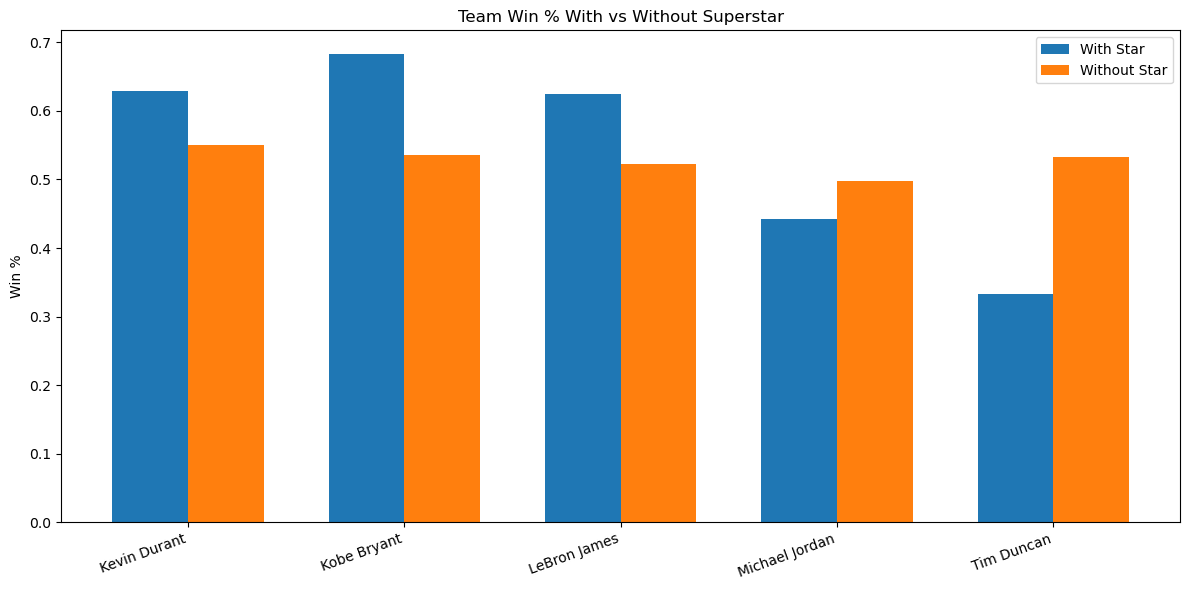

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

engine = create_engine("postgresql+psycopg2://student@/nba_project")

q = text("""
WITH stars(playerkey, player_name) AS (
  VALUES
    (893,  'Michael Jordan'),
    (2940, 'LeBron James'),
    (130,  'Kobe Bryant'),
    (3741, 'Kevin Durant'),
    (1495, 'Tim Duncan')
),
star_games AS (
    SELECT DISTINCT ps.gamekey, ps.teamkey, ps.playerkey, 1 AS with_star
    FROM player_stats_raw ps
    WHERE ps.playerkey IN (893, 2940, 130, 3741, 1495)
),
team_games AS (
    SELECT DISTINCT ts.gamekey, ts.teamkey, ts.win
    FROM team_stats_raw ts
),
player_teams AS (
    SELECT DISTINCT playerkey, teamkey
    FROM player_stats_raw
    WHERE playerkey IN (893, 2940, 130, 3741, 1495)
),
combined AS (
    SELECT
        pt.playerkey,
        tg.teamkey,
        tg.gamekey,
        COALESCE(sg.with_star, 0) AS with_star,
        tg.win
    FROM player_teams pt
    JOIN team_games tg
      ON tg.teamkey = pt.teamkey
    LEFT JOIN star_games sg
      ON sg.gamekey = tg.gamekey
     AND sg.teamkey = tg.teamkey
     AND sg.playerkey = pt.playerkey
)
SELECT
    s.player_name,
    c.with_star,
    COUNT(*) AS games,
    AVG(c.win::numeric) AS win_pct
FROM combined c
JOIN stars s ON s.playerkey = c.playerkey
GROUP BY s.player_name, c.with_star
ORDER BY s.player_name, c.with_star DESC;
""")

with engine.connect() as conn:
    df = pd.read_sql(q, conn)

# pivot to wide format for plotting
p = df.pivot(index="player_name", columns="with_star", values="win_pct")
p = p.rename(columns={1: "With Star", 0: "Without Star"}).reset_index()

# plot grouped bars
x = range(len(p["player_name"]))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], p["With Star"], width, label="With Star")
plt.bar([i + width/2 for i in x], p["Without Star"], width, label="Without Star")

plt.xticks(list(x), p["player_name"], rotation=20, ha="right")
plt.ylabel("Win %")
plt.title("Team Win % With vs Without Superstar")
plt.legend()
plt.tight_layout()
plt.show()

Comment: Runs a SQL query to compute each superstar’s team win rate with vs. without them, reshapes the results into a wide table, and visualizes the comparison as a grouped bar chart in Matplotlib.

Insights: This bar chart compares team win percentages in games with versus without five all-time superstars on the roster. For Kevin Durant, Kobe Bryant, and LeBron James, teams show a materially higher win percentage when the superstar is present, indicating strong on-court dependency and direct impact on winning outcomes. The drop in win rate when these players are absent suggests that their teams relied heavily on their scoring, playmaking, and overall on-court influence

In [ ]:
fig.savefig("visual-5.jpg", dpi=400, bbox_inches="tight")